## shNfkb1-lane2
12/12/2025 - Data generated from shNfkb1 single hairpin experiments; did not include hairpin library; data submitted by Jason/Hannah/CHP on 5/25/2023

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib 
from matplotlib import pyplot as plt

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [4]:
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/JC2438-shNfkb1.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_h5('JC2438_filtered_feature_bc_matrix.h5', gex_only=False)

reading JC2438_filtered_feature_bc_matrix.h5
 (0:00:01)


/home/chanj2/part2a/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [9]:
print(samples)

['AW1786_2117', 'AX1584_2118', 'AX1091_2118', 'AW1541_Renilla', 'AW1540_Renilla', 'AW1552_2117', 'AX1672_2118', 'AX1123_2118', 'AW1725_Renilla', 'AX1128_Renilla']


In [10]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [11]:
hashadata.var

gene_ids     feature_types genome                    pattern  \
AW1786_2117      AW1786  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1584_2118      AX1584  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1091_2118      AX1091  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1541_Renilla   AW1541  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1540_Renilla   AW1540  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1552_2117      AW1552  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1672_2118      AX1672  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1123_2118      AX1123  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AW1725_Renilla   AW1725  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   
AX1128_Renilla   AX1128  Antibody Capture         5PNNNNNNNNNN(BC)NNNNNNNNN   

               read         sequence  
AW1786_2117      R2  ACCCACCAGTAAGAC  
AX1584_2118      R2  GGTCGAGAGCATTCA  
AX1091_2118      R2  CTTGCCGCATGTCAT  
AW1541_Renilla   R2  AAAGCATTCTTCACG  
AW1540_Renilla   R2  CTTTGTCTTTGTGAG  
AW1552_2117      R2  TATGCTGCCACGGTA  
AX1672_2118      R2  GAGTCTGCCAGTATC  
AX1123_2118      R2  TATAGAACGCCAGGC  
AW1725_Renilla   R2  TGCCTATGAAACAAG  
AX1128_Renilla   R2  CCGATTGTAACAGAC

## Preprocessing

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


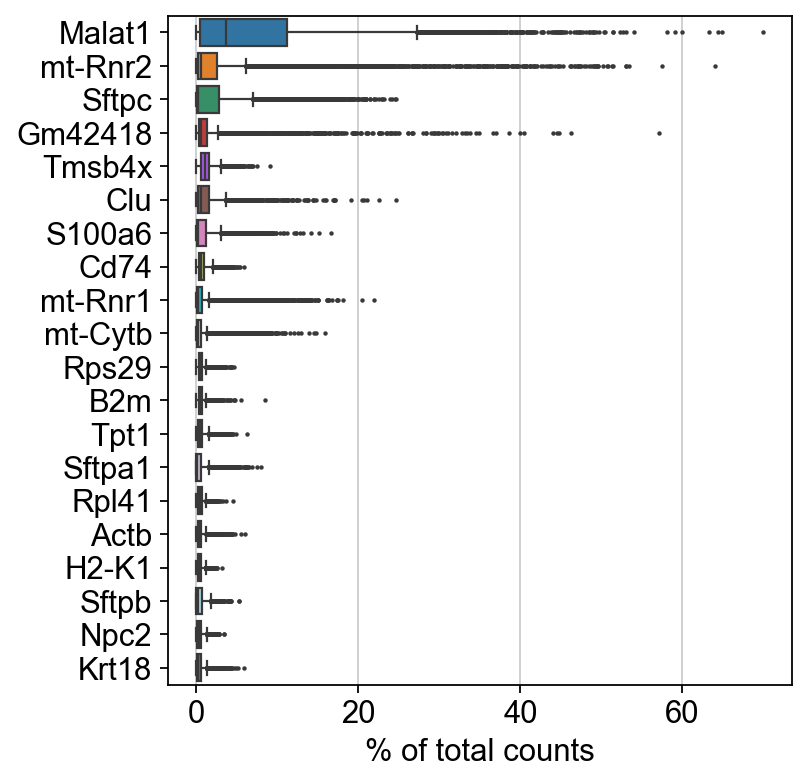

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [13]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1062 cells that have less than 1500 counts
filtered out 10 cells that have less than 300 genes expressed
filtered out 29097 genes that are detected in less than 3 cells


In [14]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

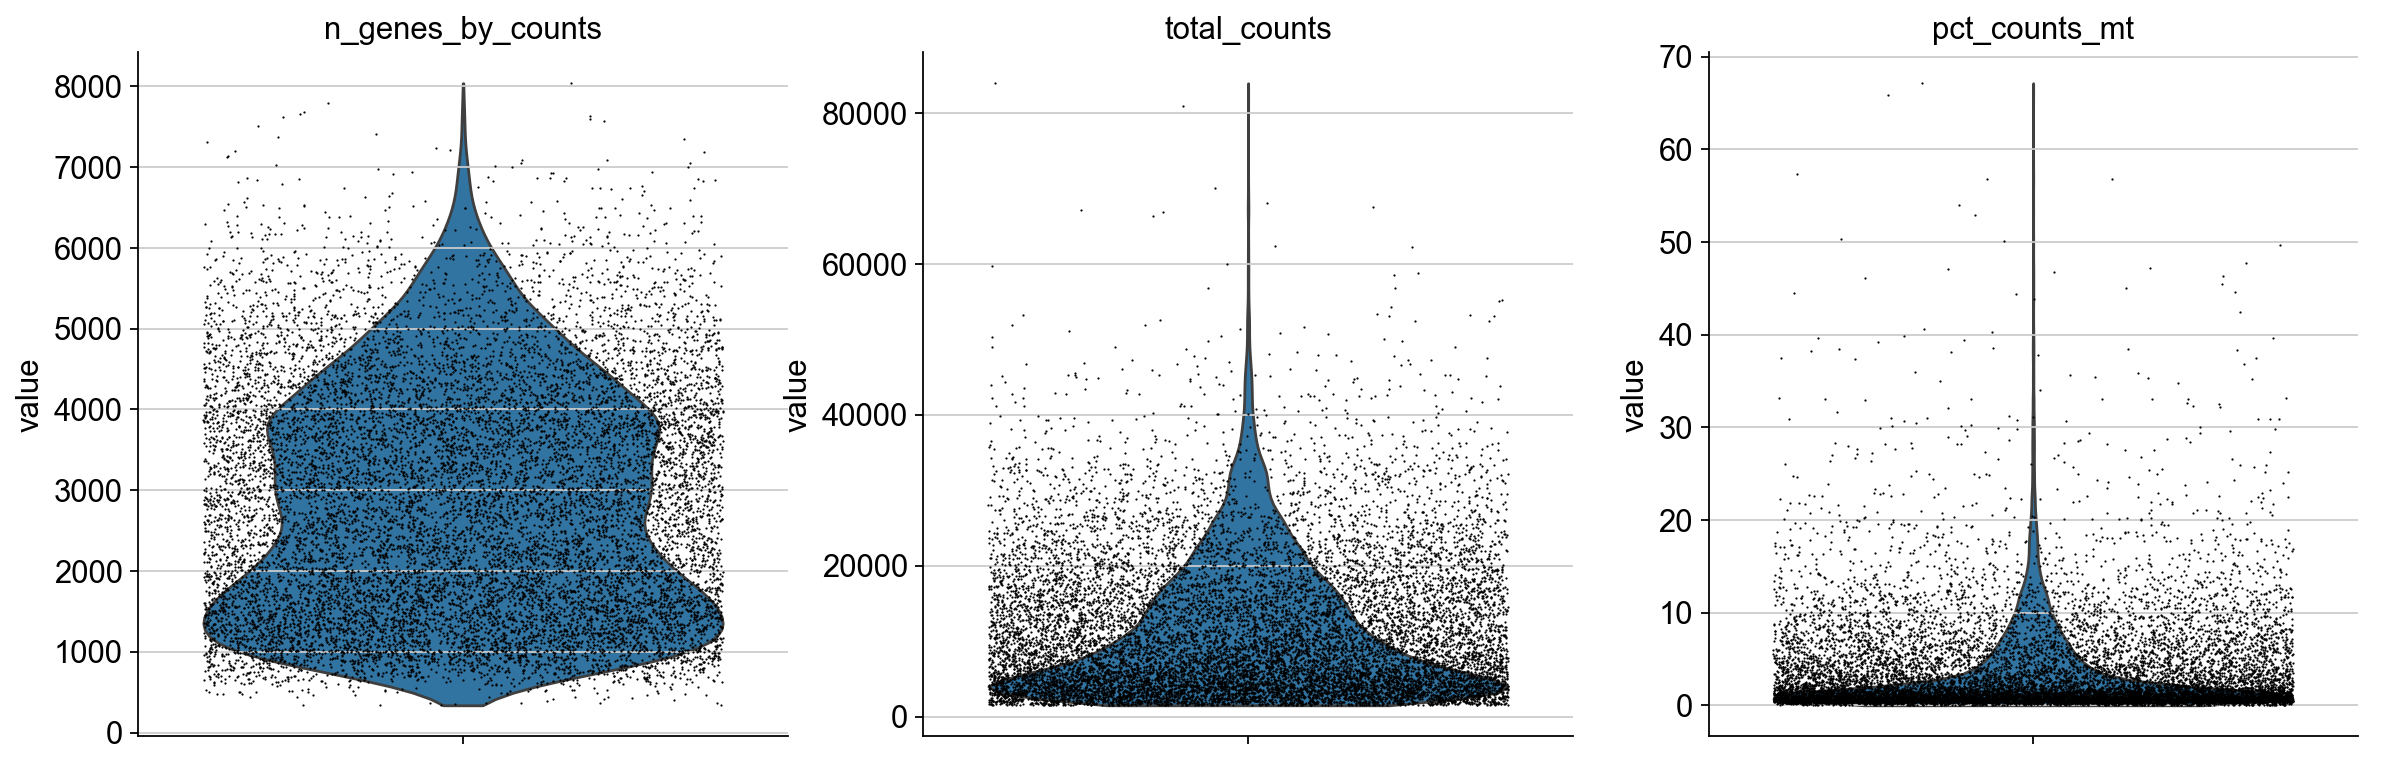

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   8.,   36.,   62.,  185., 1004., 2922., 4355., 4070., 1283.,
         109.]),
 array([0.71826401, 0.74055402, 0.76284403, 0.78513405, 0.80742406,
        0.82971407, 0.85200409, 0.8742941 , 0.89658411, 0.91887412,
        0.94116414]),
 <BarContainer object of 10 artists>)

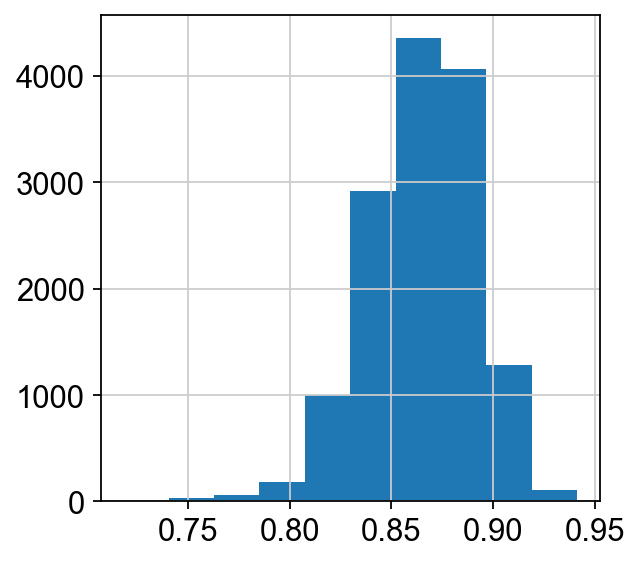

In [16]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

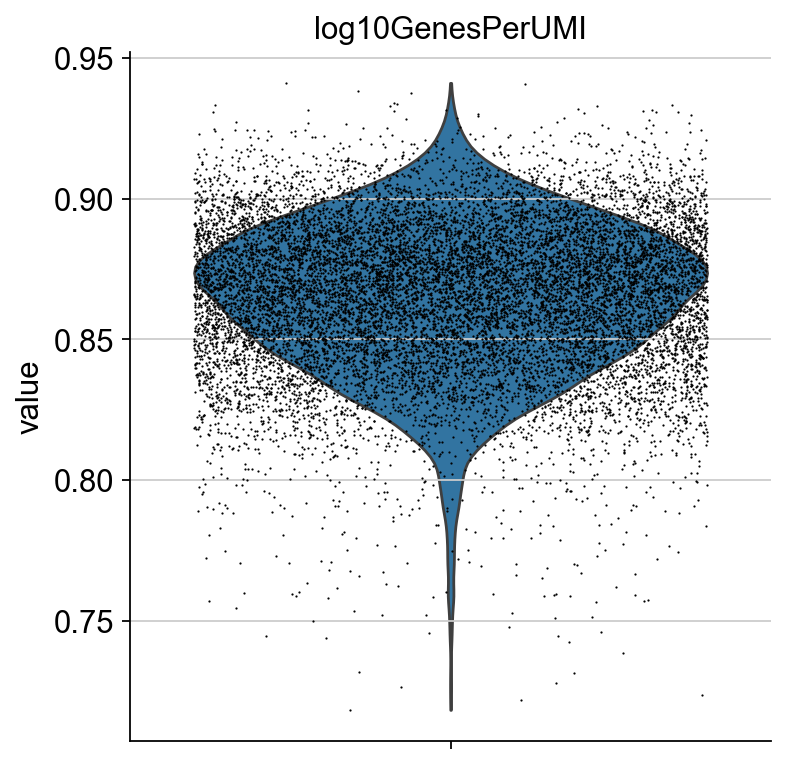

In [17]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)
#99% seems like a good Human pct count cutoff

Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [18]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [19]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [20]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [21]:
hashadata.var_names

Index(['AW1786_2117', 'AX1584_2118', 'AX1091_2118', 'AW1541_Renilla',
       'AW1540_Renilla', 'AW1552_2117', 'AX1672_2118', 'AX1123_2118',
       'AW1725_Renilla', 'AX1128_Renilla'],
      dtype='object')

In [22]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [23]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

AW1786_2117    AX1584_2118   AX1091_2118  AW1541_Renilla  \
count  13583.000000   13583.000000  13583.000000    13583.000000   
mean     345.064484     203.951416    113.888832      378.412659   
std      979.262451    1637.746216    680.087524      965.789001   
min        0.000000       0.000000      0.000000        0.000000   
10%        5.000000       2.000000      1.000000        4.000000   
20%        7.000000       3.000000      1.000000        6.000000   
30%        9.000000       4.000000      2.000000        7.000000   
40%       11.000000       5.000000      2.000000        9.000000   
50%       13.000000       6.000000      3.000000       12.000000   
60%       16.000000       8.000000      4.000000       16.000000   
70%       22.000000       9.000000      5.000000       25.400000   
80%       40.000000      12.000000      6.000000      153.600000   
90%     1352.600000      20.000000     10.000000     1478.000000   
99%     4672.060000    6089.980000   3708.900000     4580.260000   
max    11909.000000  144891.000000  18107.000000    12238.000000   

       AW1540_Renilla   AW1552_2117   AX1672_2118   AX1123_2118  \
count    13583.000000  13583.000000  13583.000000  13583.000000   
mean       344.483398    298.303467     25.896488     71.654861   
std        732.886536   1102.414429    258.398712    530.724426   
min          0.000000      0.000000      0.000000      0.000000   
10%          4.000000      6.000000      0.000000      0.000000   
20%          6.000000      8.000000      0.000000      1.000000   
30%          8.000000      9.000000      0.000000      1.000000   
40%          9.000000     11.000000      0.000000      2.000000   
50%         12.000000     13.000000      1.000000      2.000000   
60%         15.000000     15.000000      1.000000      3.000000   
70%         26.000000     18.000000      1.000000      4.000000   
80%        618.600000     25.000000      2.000000      5.000000   
90%       1339.000000    274.800000      3.000000      8.000000   
99%       3159.040000   5746.080000    843.500000   2709.560000   
max      11249.000000  18846.000000   7073.000000  11402.000000   

       AW1725_Renilla  AX1128_Renilla  
count    13583.000000    13583.000000  
mean       460.927551      137.194733  
std       1041.853271      456.041229  
min          0.000000        0.000000  
10%          7.000000        1.000000  
20%         10.000000        1.000000  
30%         12.000000        2.000000  
40%         14.000000        3.000000  
50%         17.000000        3.000000  
60%         21.000000        4.000000  
70%         32.000000        6.000000  
80%        674.600000       10.000000  
90%       1850.400000      399.000000  
99%       4606.080000     2328.800000  
max      16624.000000     7290.000000

In [24]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

AW1786_2117
1352.6000000000022
AX1584_2118
20.0
AX1091_2118
10.0
AW1541_Renilla
1478.0
AW1540_Renilla
1339.0
AW1552_2117
274.8000000000011
AX1672_2118
3.0
AX1123_2118
8.0
AW1725_Renilla
1850.4000000000033
AX1128_Renilla
399.0


/tmp/ipykernel_1960023/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_1960023/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/tmp/ipykernel_1960023/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' has dtype incompatible with float32, please exp

AW1786_2117  AX1584_2118  AX1091_2118  AW1541_Renilla  \
AAACCCAAGACTGAGC-1        False        False        False           False   
AAACCCAAGATAGTGT-1        False        False        False           False   
AAACCCAAGGGATGTC-1        False        False        False           False   
AAACCCAAGTAGGATT-1        False        False        False           False   
AAACCCACAACACAAA-1        False        False        False           False   
...                         ...          ...          ...             ...   
TTTGTTGTCATTGCTT-1        False         True        False           False   
TTTGTTGTCCGCGAGT-1        False        False        False           False   
TTTGTTGTCGATGCTA-1        False        False         True           False   
TTTGTTGTCTCTAGGA-1        False         True        False           False   
TTTGTTGTCTGTACAG-1        False        False        False           False   

                    AW1540_Renilla  AW1552_2117  AX1672_2118  AX1123_2118  \
AAACCCAAGACTGAGC-1           False        False        False        False   
AAACCCAAGATAGTGT-1           False        False        False        False   
AAACCCAAGGGATGTC-1           False        False        False        False   
AAACCCAAGTAGGATT-1           False        False        False        False   
AAACCCACAACACAAA-1           False         True        False        False   
...                            ...          ...          ...          ...   
TTTGTTGTCATTGCTT-1           False        False        False        False   
TTTGTTGTCCGCGAGT-1           False        False        False        False   
TTTGTTGTCGATGCTA-1           False        False        False        False   
TTTGTTGTCTCTAGGA-1           False        False         True        False   
TTTGTTGTCTGTACAG-1           False        False        False        False   

                    AW1725_Renilla  AX1128_Renilla  
AAACCCAAGACTGAGC-1            True           False  
AAACCCAAGATAGTGT-1            True           False  
AAACCCAAGGGATGTC-1           False           False  
AAACCCAAGTAGGATT-1           False           False  
AAACCCACAACACAAA-1           False           False  
...                            ...             ...  
TTTGTTGTCATTGCTT-1           False           False  
TTTGTTGTCCGCGAGT-1           False           False  
TTTGTTGTCGATGCTA-1           False           False  
TTTGTTGTCTCTAGGA-1           False           False  
TTTGTTGTCTGTACAG-1           False            True  

[13583 rows x 10 columns]

In [25]:
from matplotlib import pyplot as plt

In [26]:
hashCounts

AW1786_2117  AX1584_2118  AX1091_2118  AW1541_Renilla  \
AAACCCAAGACTGAGC-1          6.0          6.0          2.0            12.0   
AAACCCAAGATAGTGT-1          4.0          7.0          0.0             9.0   
AAACCCAAGGGATGTC-1        301.0          3.0          2.0             6.0   
AAACCCAAGTAGGATT-1         14.0          9.0          7.0            10.0   
AAACCCACAACACAAA-1          9.0          7.0          2.0            10.0   
...                         ...          ...          ...             ...   
TTTGTTGTCATTGCTT-1         20.0       4498.0          2.0             7.0   
TTTGTTGTCCGCGAGT-1         65.0          8.0          2.0           722.0   
TTTGTTGTCGATGCTA-1         17.0         11.0       1474.0            12.0   
TTTGTTGTCTCTAGGA-1          7.0         46.0          0.0            11.0   
TTTGTTGTCTGTACAG-1          3.0          7.0          3.0             5.0   

                    AW1540_Renilla  AW1552_2117  AX1672_2118  AX1123_2118  \
AAACCCAAGACTGAGC-1            13.0          8.0          0.0          1.0   
AAACCCAAGATAGTGT-1             2.0          8.0          2.0          2.0   
AAACCCAAGGGATGTC-1             5.0          5.0          0.0          3.0   
AAACCCAAGTAGGATT-1             6.0          7.0          0.0          3.0   
AAACCCACAACACAAA-1            12.0       4713.0          2.0          2.0   
...                            ...          ...          ...          ...   
TTTGTTGTCATTGCTT-1             6.0          7.0          3.0          1.0   
TTTGTTGTCCGCGAGT-1           981.0          6.0          0.0          0.0   
TTTGTTGTCGATGCTA-1            11.0         10.0          0.0          3.0   
TTTGTTGTCTCTAGGA-1            16.0         13.0       1303.0          2.0   
TTTGTTGTCTGTACAG-1            10.0         12.0          0.0          0.0   

                    AW1725_Renilla  AX1128_Renilla  
AAACCCAAGACTGAGC-1          2538.0             5.0  
AAACCCAAGATAGTGT-1          2048.0             1.0  
AAACCCAAGGGATGTC-1            18.0             4.0  
AAACCCAAGTAGGATT-1           721.0             6.0  
AAACCCACAACACAAA-1             7.0            12.0  
...                            ...             ...  
TTTGTTGTCATTGCTT-1           382.0             2.0  
TTTGTTGTCCGCGAGT-1             8.0             3.0  
TTTGTTGTCGATGCTA-1            21.0             1.0  
TTTGTTGTCTCTAGGA-1             8.0             0.0  
TTTGTTGTCTGTACAG-1             7.0           535.0  

[13583 rows x 10 columns]

In [27]:
plt.rcParams['figure.figsize'] = (4,4)

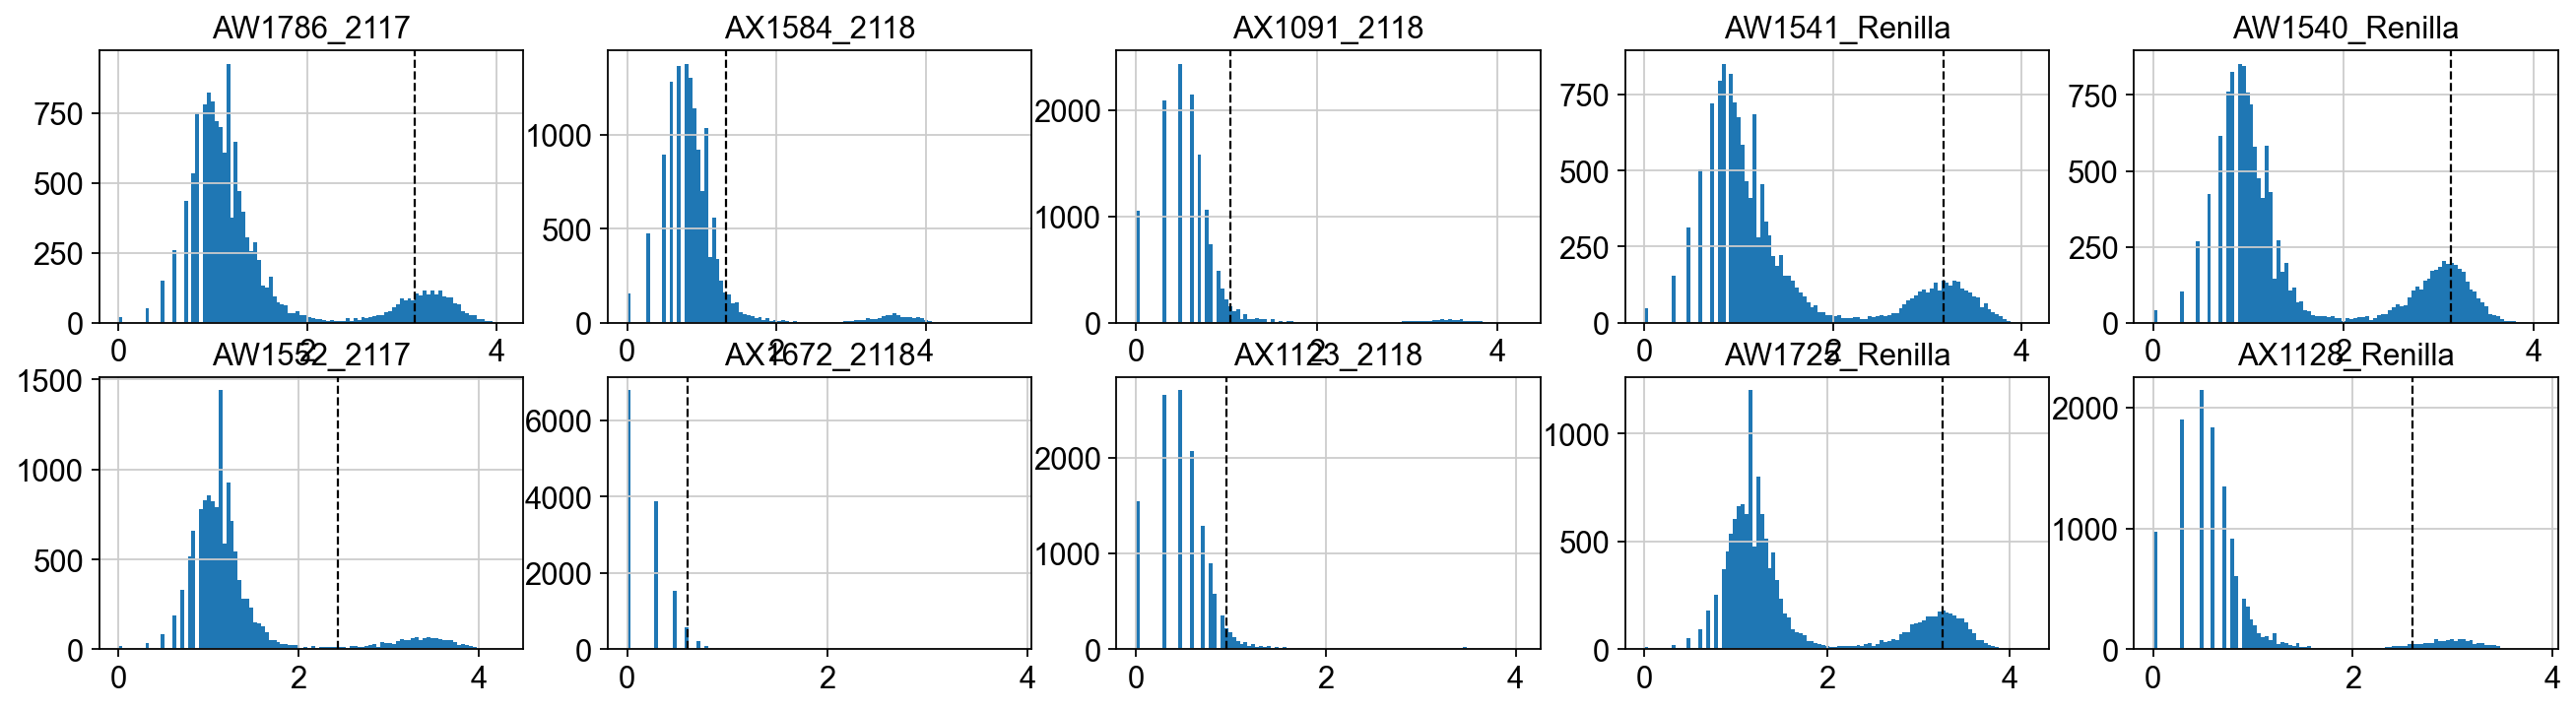

In [28]:
fig, axs = plt.subplots(2,5, figsize =(20, 5))

for i, hashName in enumerate(hashadata.var_names):
    hashCounts2 = np.log10(hashCounts[hashName]+1)
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].hist(hashCounts2, bins = 100)
    axs[i//5,i%5].axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)

#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

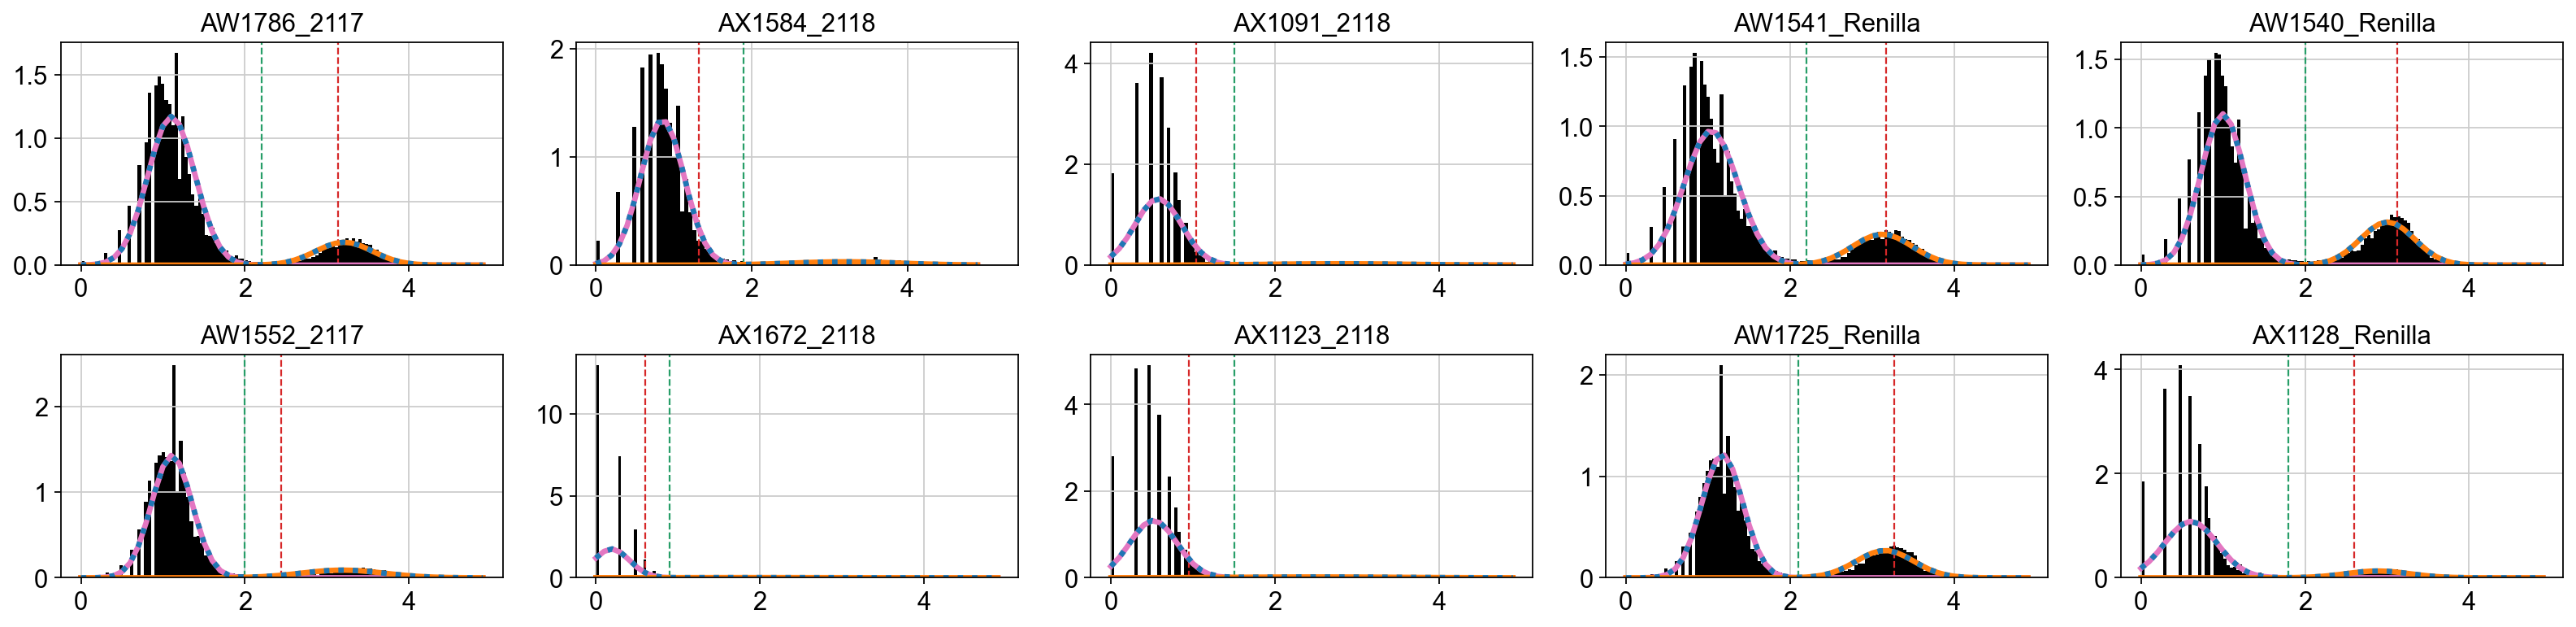

In [29]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    if mean[0][0] < mean[1][0]:
        left_idx, right_idx = 0, 1
    else:
        left_idx, right_idx = 1, 0

    
    x_axis = np.arange(0, 5, 0.1)
    
    y_left = norm.pdf(x_axis, float(mean[left_idx][0]), np.sqrt(float(covs[left_idx][0][0]))) * weights[left_idx]
    y_right = norm.pdf(x_axis, float(mean[right_idx][0]), np.sqrt(float(covs[right_idx][0][0]))) * weights[right_idx]

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]  

    diff = y_right - y_left
    crossings = np.where(np.diff(np.sign(diff)) > 0)[0]  # where right overtakes left
    
    if len(crossings) > 0:
        # Take the first crossing where right becomes dominant
        idx = crossings[0]
        hashBoundry = x_axis[idx + 1]  # slightly to the right
    else:
        # If no intersection found, fall back to right mean or a fixed value
        hashBoundry = float(mean[right_idx][0])

    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_left, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_right, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_left+y_right, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [30]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
#set manual minimum threshold to be 1
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    #manually set minimum threshold to 1 given poor HashData
    if (dfHashBoundry.loc[hashName].values[0] < 1):
        dfHashBoundry.loc[hashName].values[0] = 1
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

AW1786_2117
2.2
2.2
AX1584_2118
1.9000000000000001
1.9000000000000001
AX1091_2118
1.5
1.5
AW1541_Renilla
2.2
2.2
AW1540_Renilla
2.0
2.0
AW1552_2117
2.0
2.0
AX1672_2118
0.9
1.0
AX1123_2118
1.5
1.5
AW1725_Renilla
2.1
2.1
AX1128_Renilla
1.8
1.8


/tmp/ipykernel_1960023/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False  True ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_1960023/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/tmp/ipykernel_1960023/4060069450.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ...  True False False]' ha

In [31]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    #print(i)
    #print(hashBool)
    #print(hashBool.values)
    #print(sum(hashBool))
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [32]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/tmp/ipykernel_1960023/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/tmp/ipykernel_1960023/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
doublet           2723
AW1540_Renilla    2414
AW1725_Renilla    2085
AW1541_Renilla    1762
AW1786_2117       1399
AX1128_Renilla    1061
AW1552_2117        942
AX1584_2118        381
AX1091_2118        369
AX1123_2118        216
AX1672_2118        125
negative           106
Name: count, dtype: int64

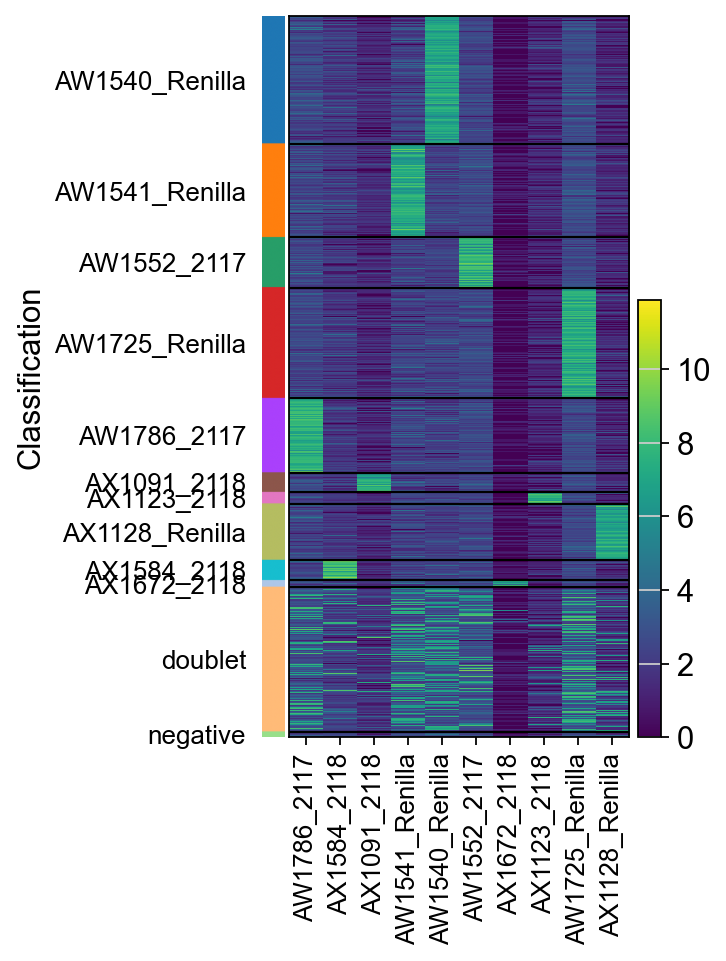

In [33]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set specialized gene counts

(array([1.2538e+04, 6.4700e+02, 2.4600e+02, 9.6000e+01, 2.6000e+01,
        1.6000e+01, 7.0000e+00, 6.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  8.80000019, 17.60000038, 26.40000153, 35.20000076,
        44.        , 52.80000305, 61.60000229, 70.40000153, 79.20000458,
        88.        ]),
 <BarContainer object of 10 artists>)

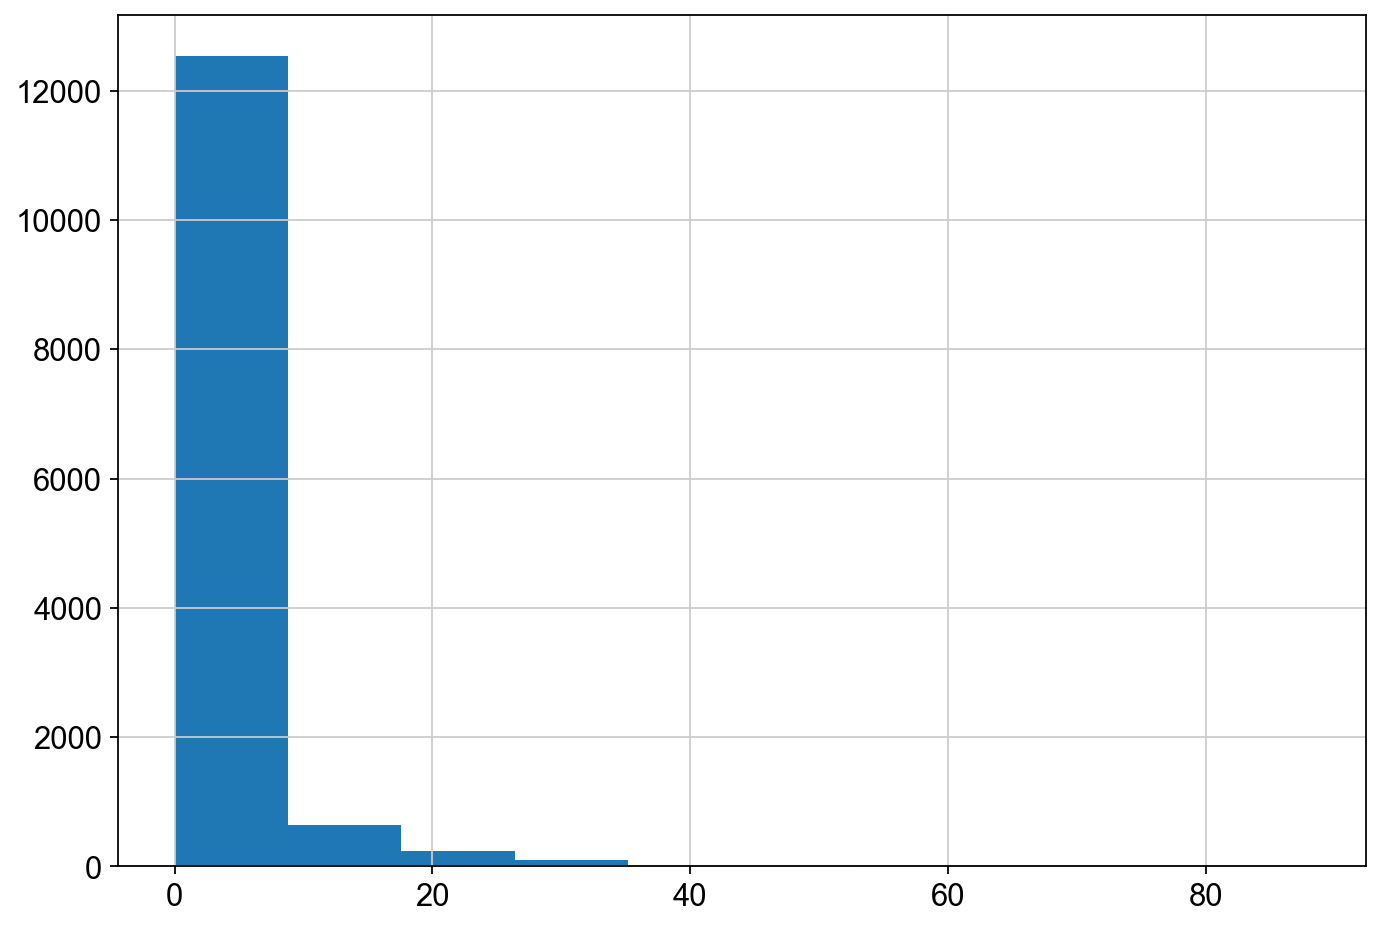

In [34]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['shRenilla'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['shRen'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [35]:
adata.obs['shRen'] = adata.X[:,adata.var.index.isin(['shRenilla'])].toarray()

(array([1.3337e+04, 1.2200e+02, 6.9000e+01, 2.4000e+01, 1.8000e+01,
        1.0000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  5.69999981, 11.39999962, 17.09999847, 22.79999924,
        28.5       , 34.19999695, 39.89999771, 45.59999847, 51.29999924,
        57.        ]),
 <BarContainer object of 10 artists>)

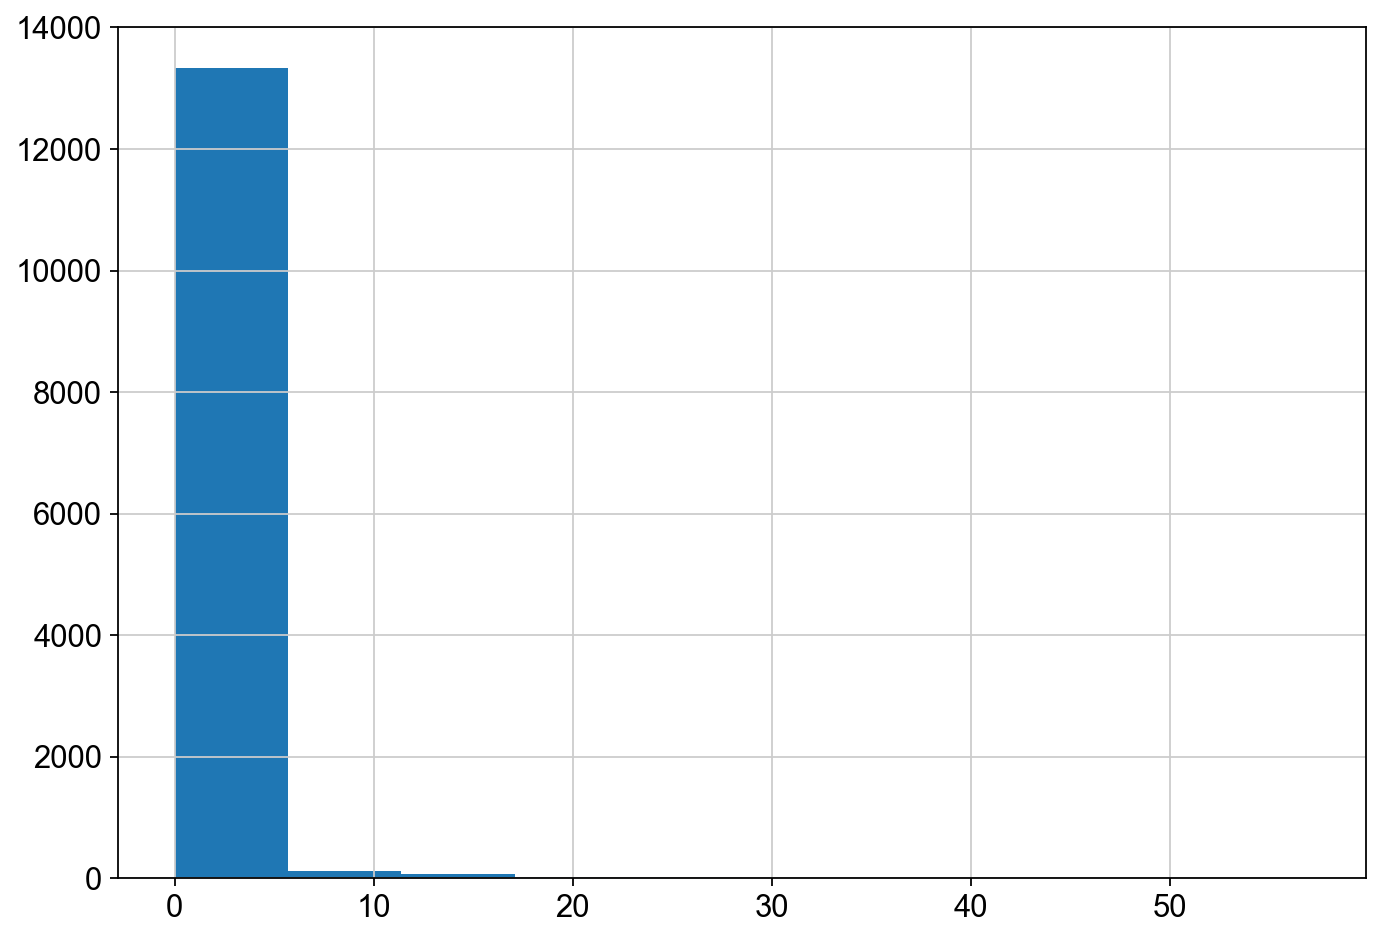

In [36]:
#Remove any cell with PTPRC counts
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray())
#ax.axvline(np.log10(int(hashDisc.loc["90%",hashName])+1), color='k', linestyle='dashed', linewidth=1)
# Show plot
#adata.obs['2118-Nfkb1.3737'] = 0

#adata.obs['shRenilla'][adata.X[:,adata.var.index.isin(['shRenilla'])] >0] #= adata.X[:,adata.var.index.isin(['shRenilla'])]

In [37]:
adata.obs['2118-Nfkb1'] = adata.X[:,adata.var.index.isin(['2118-Nfkb1.3737'])].toarray()

(array([1.3197e+04, 2.3400e+02, 1.0400e+02, 3.0000e+01, 9.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  8.89999962, 17.79999924, 26.69999886, 35.59999847,
        44.5       , 53.39999771, 62.29999542, 71.19999695, 80.09999847,
        89.        ]),
 <BarContainer object of 10 artists>)

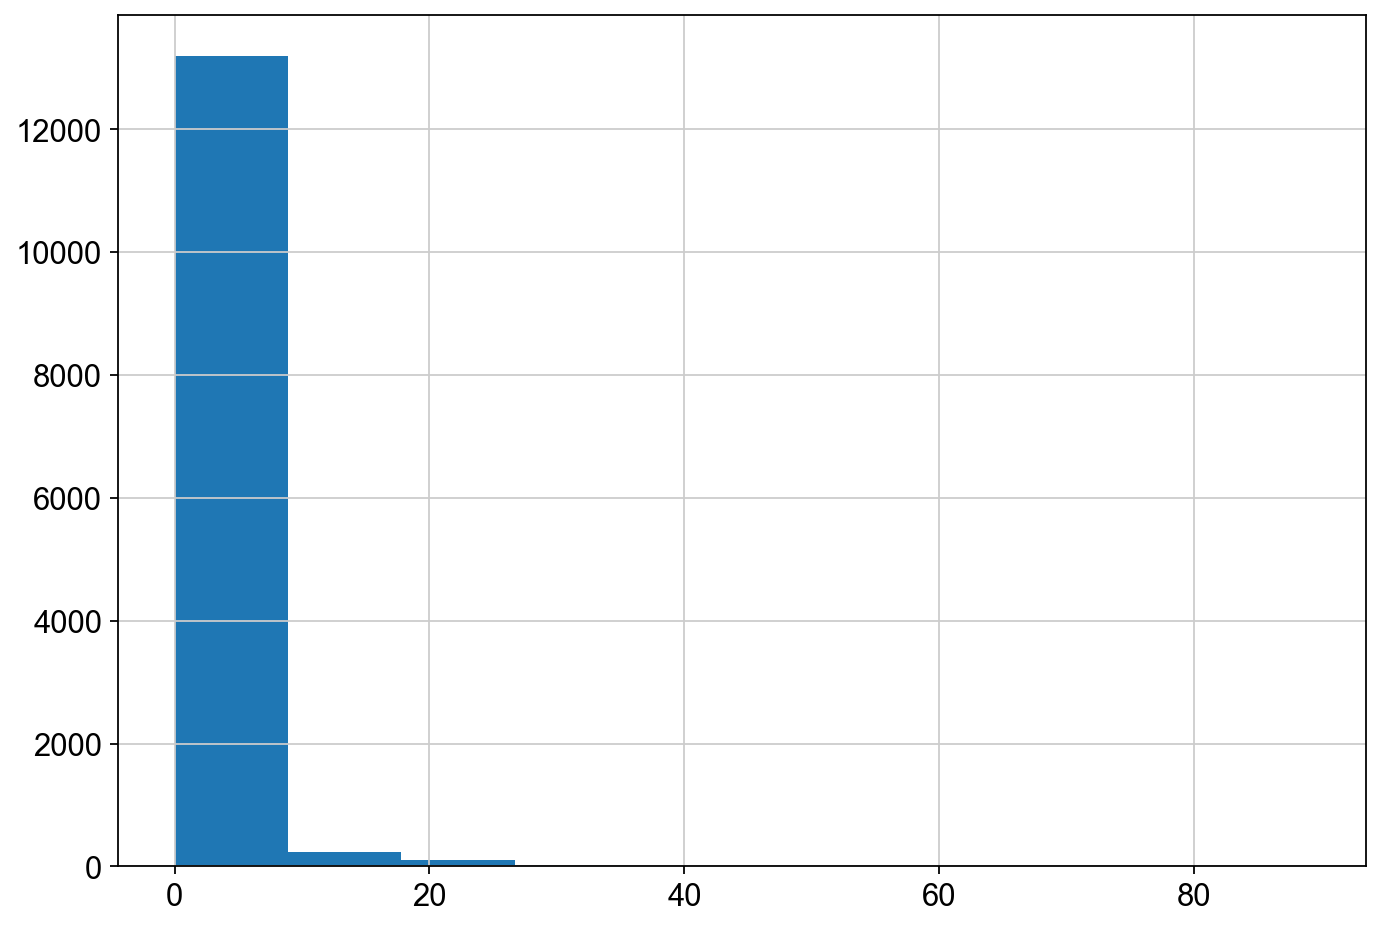

In [38]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray())

In [39]:
adata.obs['2117-Nfkb1'] = adata.X[:,adata.var.index.isin(['2117-Nfkb1.2331'])].toarray()

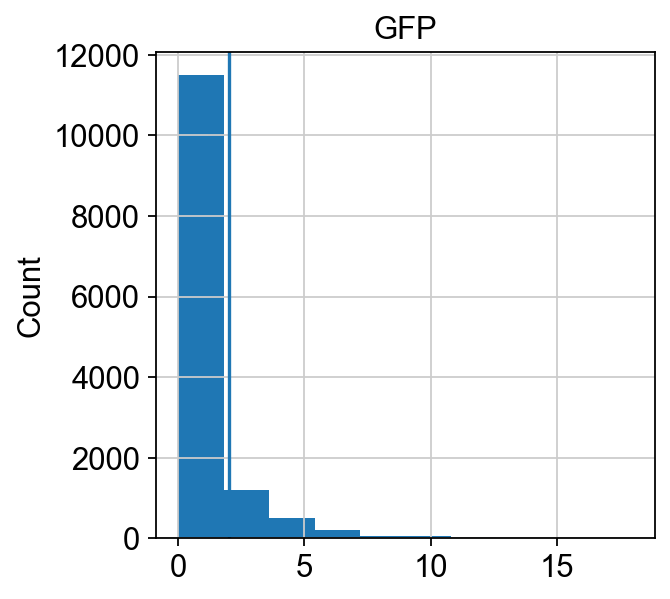

In [40]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'GFP'].X.toarray())
plt.ylabel("Count")
plt.title("GFP")
plt.axvline(x=2)
plt.show()

In [41]:
adata.obs['GFP_count'] = adata.X[:,adata.var.index.isin(['GFP'])].toarray()

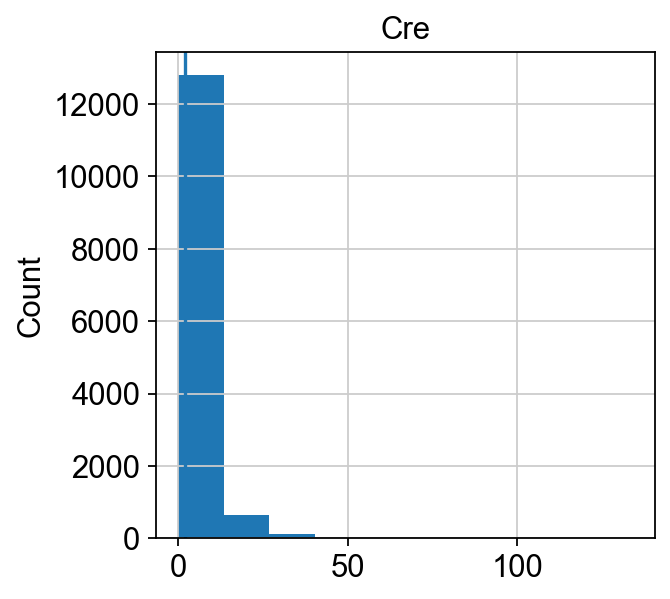

In [42]:
import matplotlib.pyplot as plt
adata.var.index.isin(['GFP'])
_ = plt.hist(adata[adata.obs.index,'Cre'].X.toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [43]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

## Filter doublets and negative cells

In [44]:
adata.obs.Classification.value_counts()

Classification
doublet           2723
AW1540_Renilla    2414
AW1725_Renilla    2085
AW1541_Renilla    1762
AW1786_2117       1399
AX1128_Renilla    1061
AW1552_2117        942
AX1584_2118        381
AX1091_2118        369
AX1123_2118        216
AX1672_2118        125
negative           106
Name: count, dtype: int64

In [45]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [46]:
adata.obs.Classification.value_counts()

Classification
AW1540_Renilla    2414
AW1725_Renilla    2085
AW1541_Renilla    1762
AW1786_2117       1399
AX1128_Renilla    1061
AW1552_2117        942
AX1584_2118        381
AX1091_2118        369
AX1123_2118        216
AX1672_2118        125
Name: count, dtype: int64

## Set Groups

In [47]:
#Set shRNA groups
adata.obs['shRNA'] = None
adata.obs['shRNA'][adata[adata.obs['shRen'] >= 2,:].obs.index] = 'shRenilla'
adata.obs['shRNA'][adata[adata.obs['2117-Nfkb1'] >= 2,:].obs.index] = '2117'
adata.obs['shRNA'][adata[adata.obs['2118-Nfkb1'] >= 2,:].obs.index] = '2118'

/tmp/ipykernel_1960023/4115219045.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['shRNA'] = None
/tmp/ipykernel_1960023/4115219045.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [48]:
adata.obs.Classification.value_counts()

Classification
AW1540_Renilla    2414
AW1725_Renilla    2085
AW1541_Renilla    1762
AW1786_2117       1399
AX1128_Renilla    1061
AW1552_2117        942
AX1584_2118        381
AX1091_2118        369
AX1123_2118        216
AX1672_2118        125
Name: count, dtype: int64

In [49]:
#Select control mice
adata = adata[adata.obs.Classification.isin(['AW1725_Renilla','AX1128_Renilla','AW1552_2117','AX1123_2118','AX1672_2118']),:]

In [50]:
#Set shRNA groups
adata.obs['Group'] = 'Renilla_Control'
adata.obs['Group'][adata.obs.Classification.isin(['AW1552_2117'])] = '2117_Control'
adata.obs['Group'][adata.obs.Classification.isin(['AX1123_2118','AX1672_2118'])] = '2118_Control'

/tmp/ipykernel_1960023/752105841.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = 'Renilla_Control'
/tmp/ipykernel_1960023/752105841.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [51]:
adata.obs[['Group','Classification']].value_counts(sort=False)

Group            Classification
2117_Control     AW1552_2117        942
2118_Control     AX1123_2118        216
                 AX1672_2118        125
Renilla_Control  AW1725_Renilla    2085
                 AX1128_Renilla    1061
Name: count, dtype: int64

## Double check shRNAs and filter accordingly

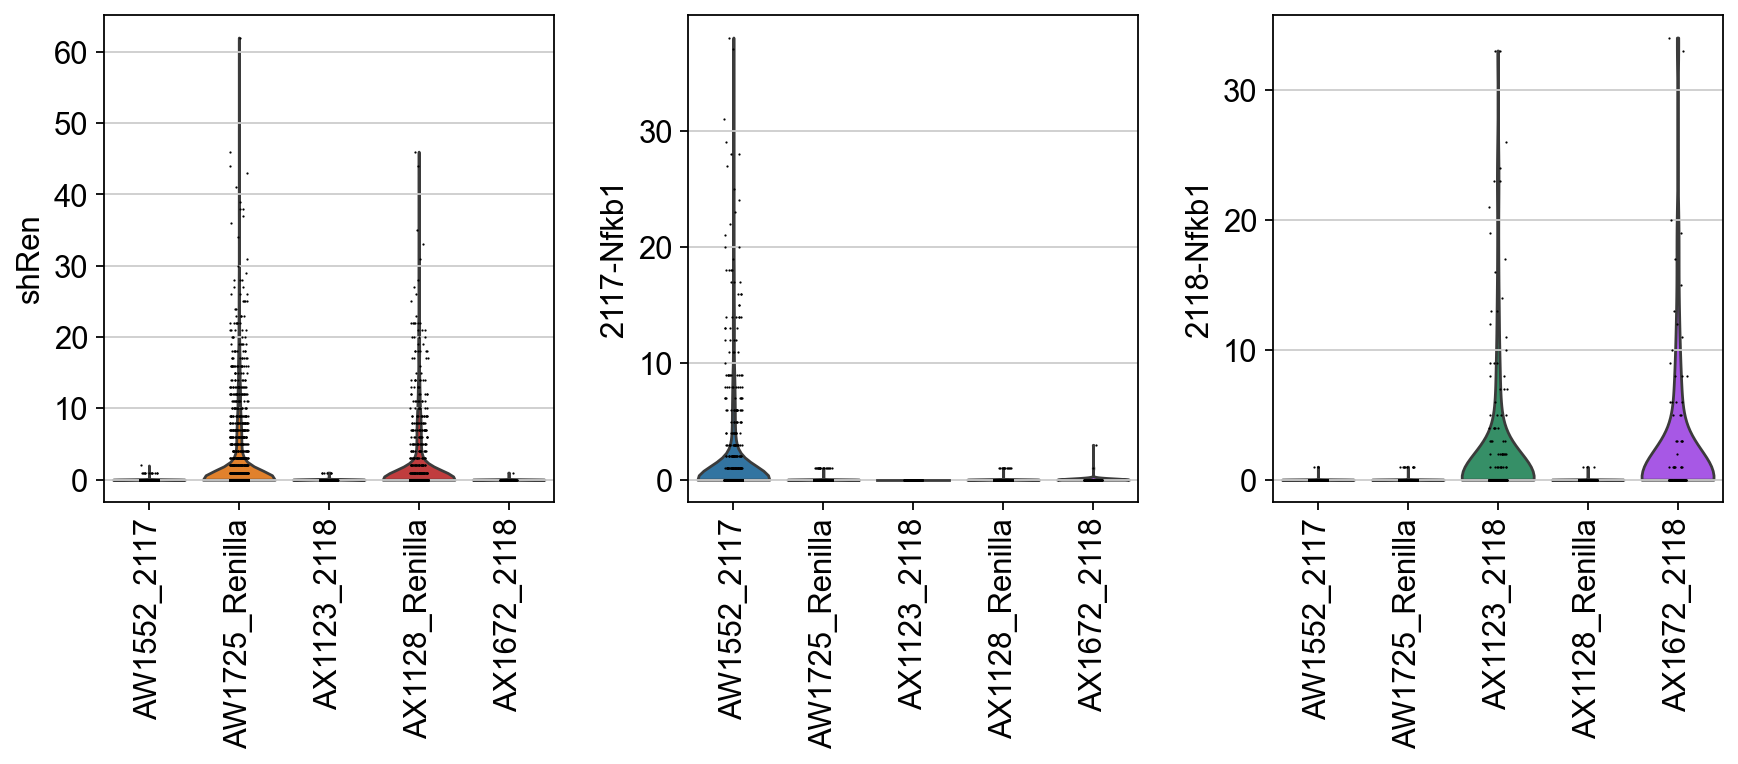

In [52]:
sc.pl.violin(adata,['shRen','2117-Nfkb1','2118-Nfkb1'], groupby='Classification', rotation=90)

In [53]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group          
shRenilla  Renilla_Control    715
2117       2117_Control       155
2118       2118_Control        76
2117       2118_Control         1
shRenilla  2117_Control         1
Name: count, dtype: int64

In [54]:
# remove 'doublet' by hairpin detection
adata = adata[~((adata.obs.shRNA.isin(['shRenilla']) & adata.obs.Group.isin(['2117_Control'])) | (adata.obs.shRNA.isin(['2117']) & adata.obs.Group.isin(['2118_Control']))),:]

In [55]:
adata.obs[['shRNA','Group']].value_counts()

shRNA      Group          
shRenilla  Renilla_Control    715
2117       2117_Control       155
2118       2118_Control        76
Name: count, dtype: int64

/home/chanj2/part2a/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


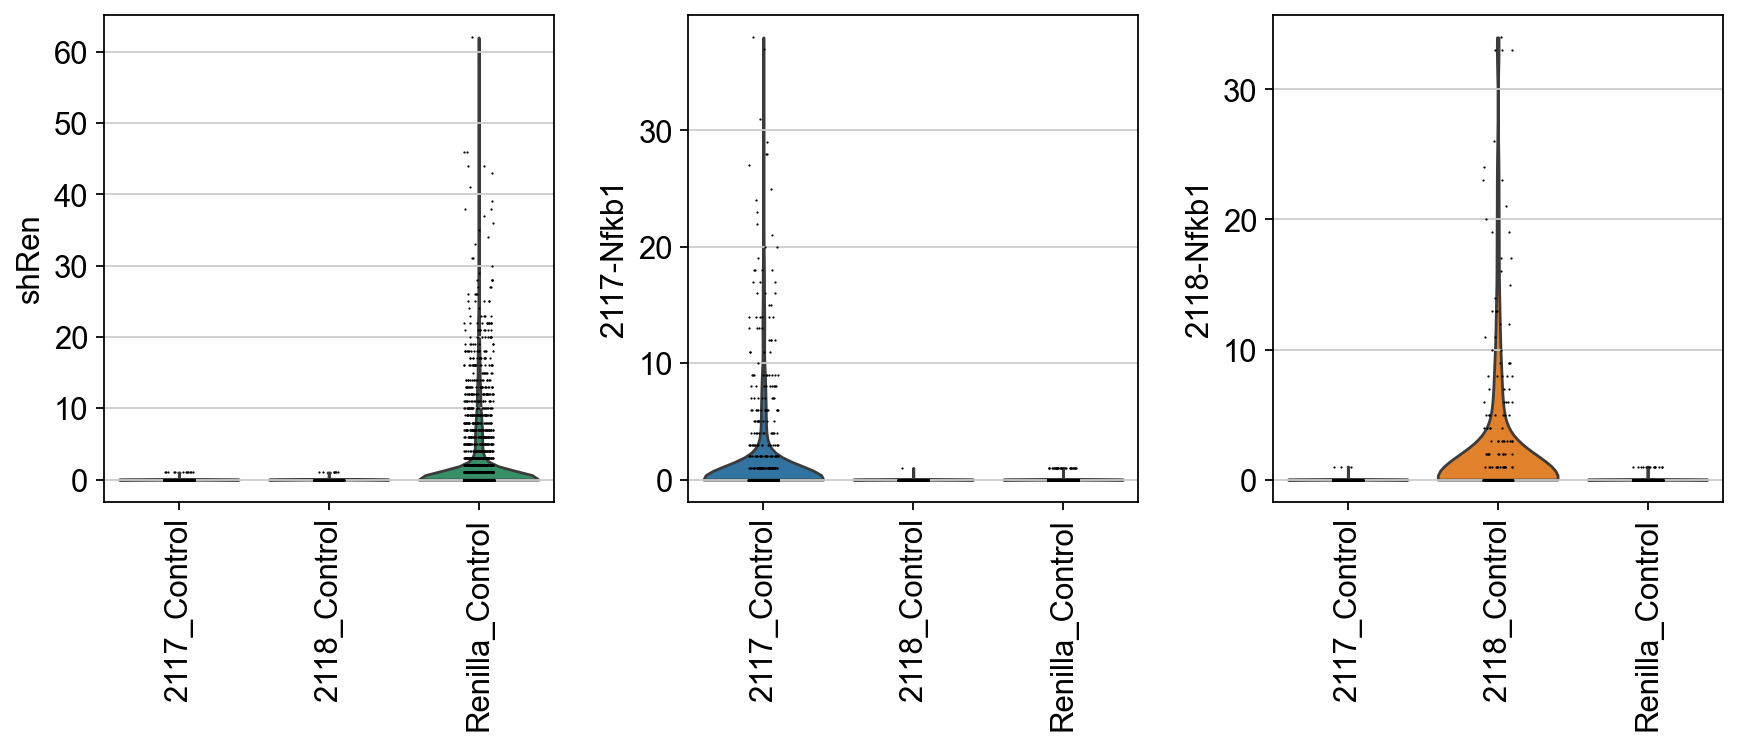

In [56]:
sc.pl.violin(adata,['shRen','2117-Nfkb1','2118-Nfkb1'], groupby='Group', rotation=90)

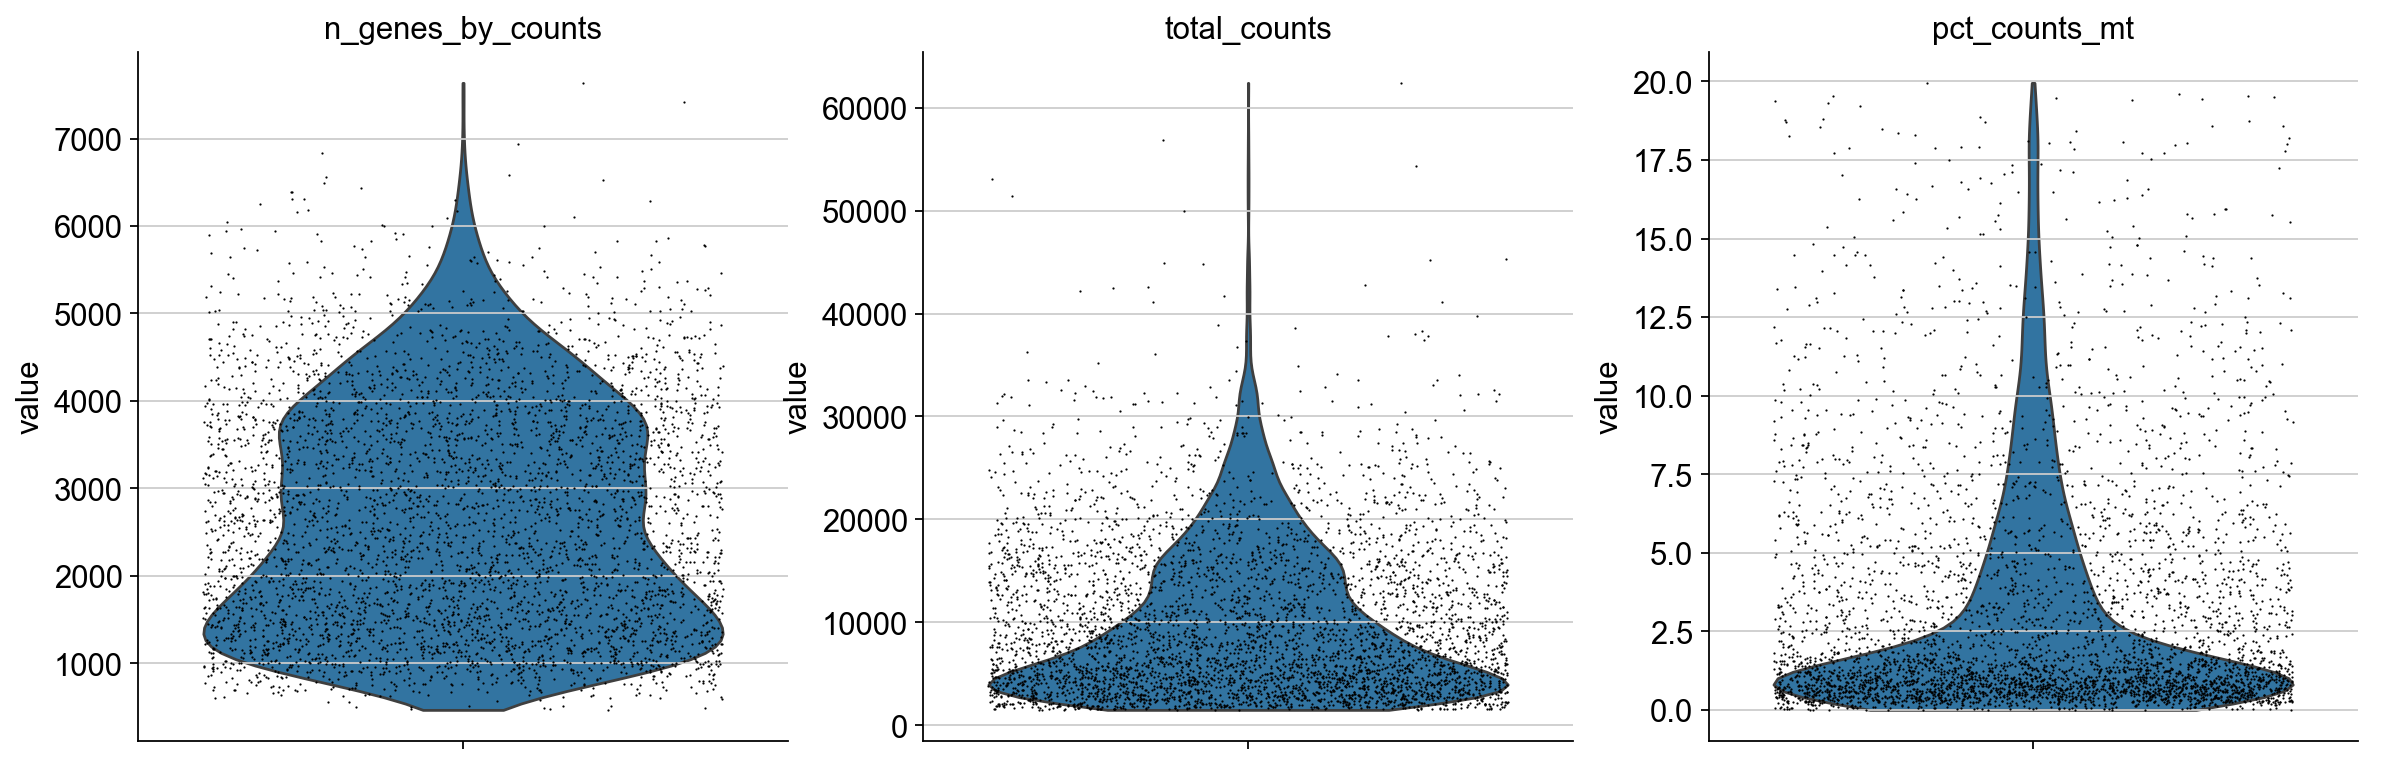

In [57]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [58]:
adata.layers['counts']=adata.X.copy()

In [59]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [60]:
sc.pp.log1p(adata)

In [61]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


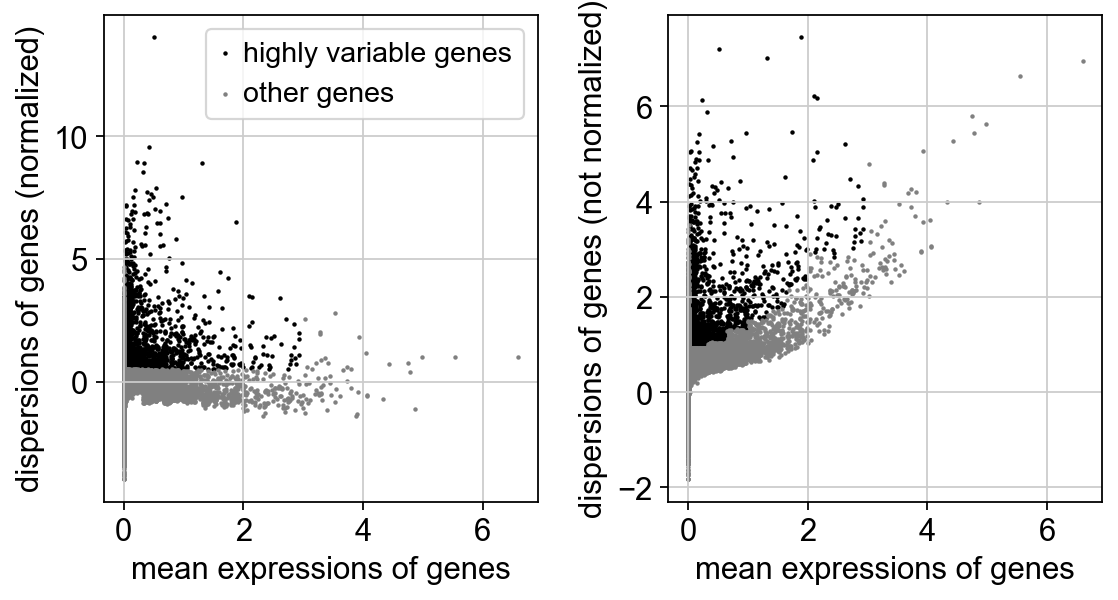

In [62]:
sc.pl.highly_variable_genes(adata)

In [63]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","2190-Jun_2481","2191-Jun_3136","2193-JunB_406","2194-JunD_78","2195-JunD_859","JCP618-Rela_1202","JCP621-Rela_1182","JCP623-Rel_1868","JCP625-Rel_342","JCP628-Ikbkg_2526","JCP629-Ikbkg_2984"]

In [64]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_1960023/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_1960023/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [65]:
adata.raw = adata

In [66]:
adata.write_h5ad('write/JC2438-allmice.h5ad', compression='gzip')

In [67]:
sc.pp.scale(adata, max_value=10)

/home/chanj2/part2a/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [68]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:04)


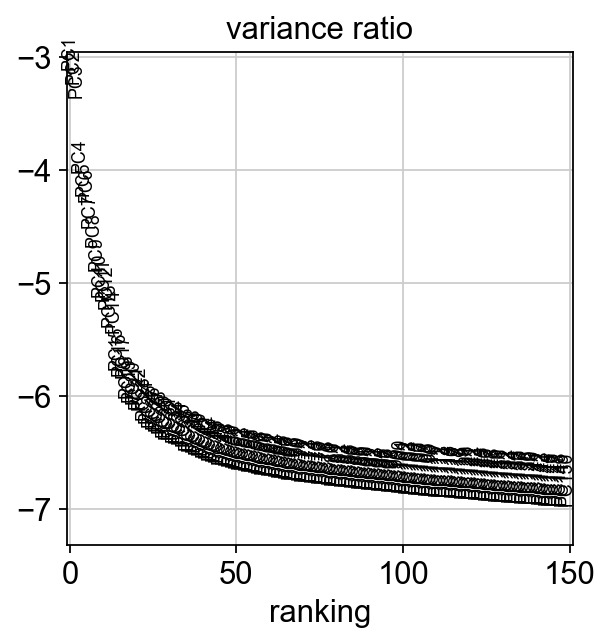

In [69]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

In [70]:
adata.write(results_file, compression='gzip')

In [71]:
adata

AnnData object with n_obs × n_vars = 4427 × 25776
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'shRen', '2118-Nfkb1', '2117-Nfkb1', 'GFP_count', 'Cre_count', 'shRNA', 'Group'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Classification_colors', 'Group_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

In [72]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/chanj2/part2a/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [73]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:16)


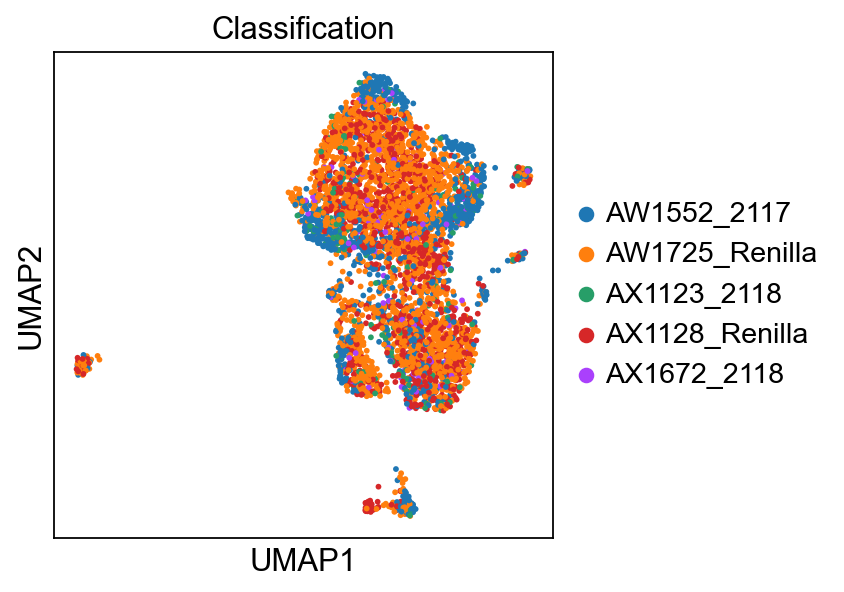

In [74]:
sc.pl.umap(adata, color=['Classification'])

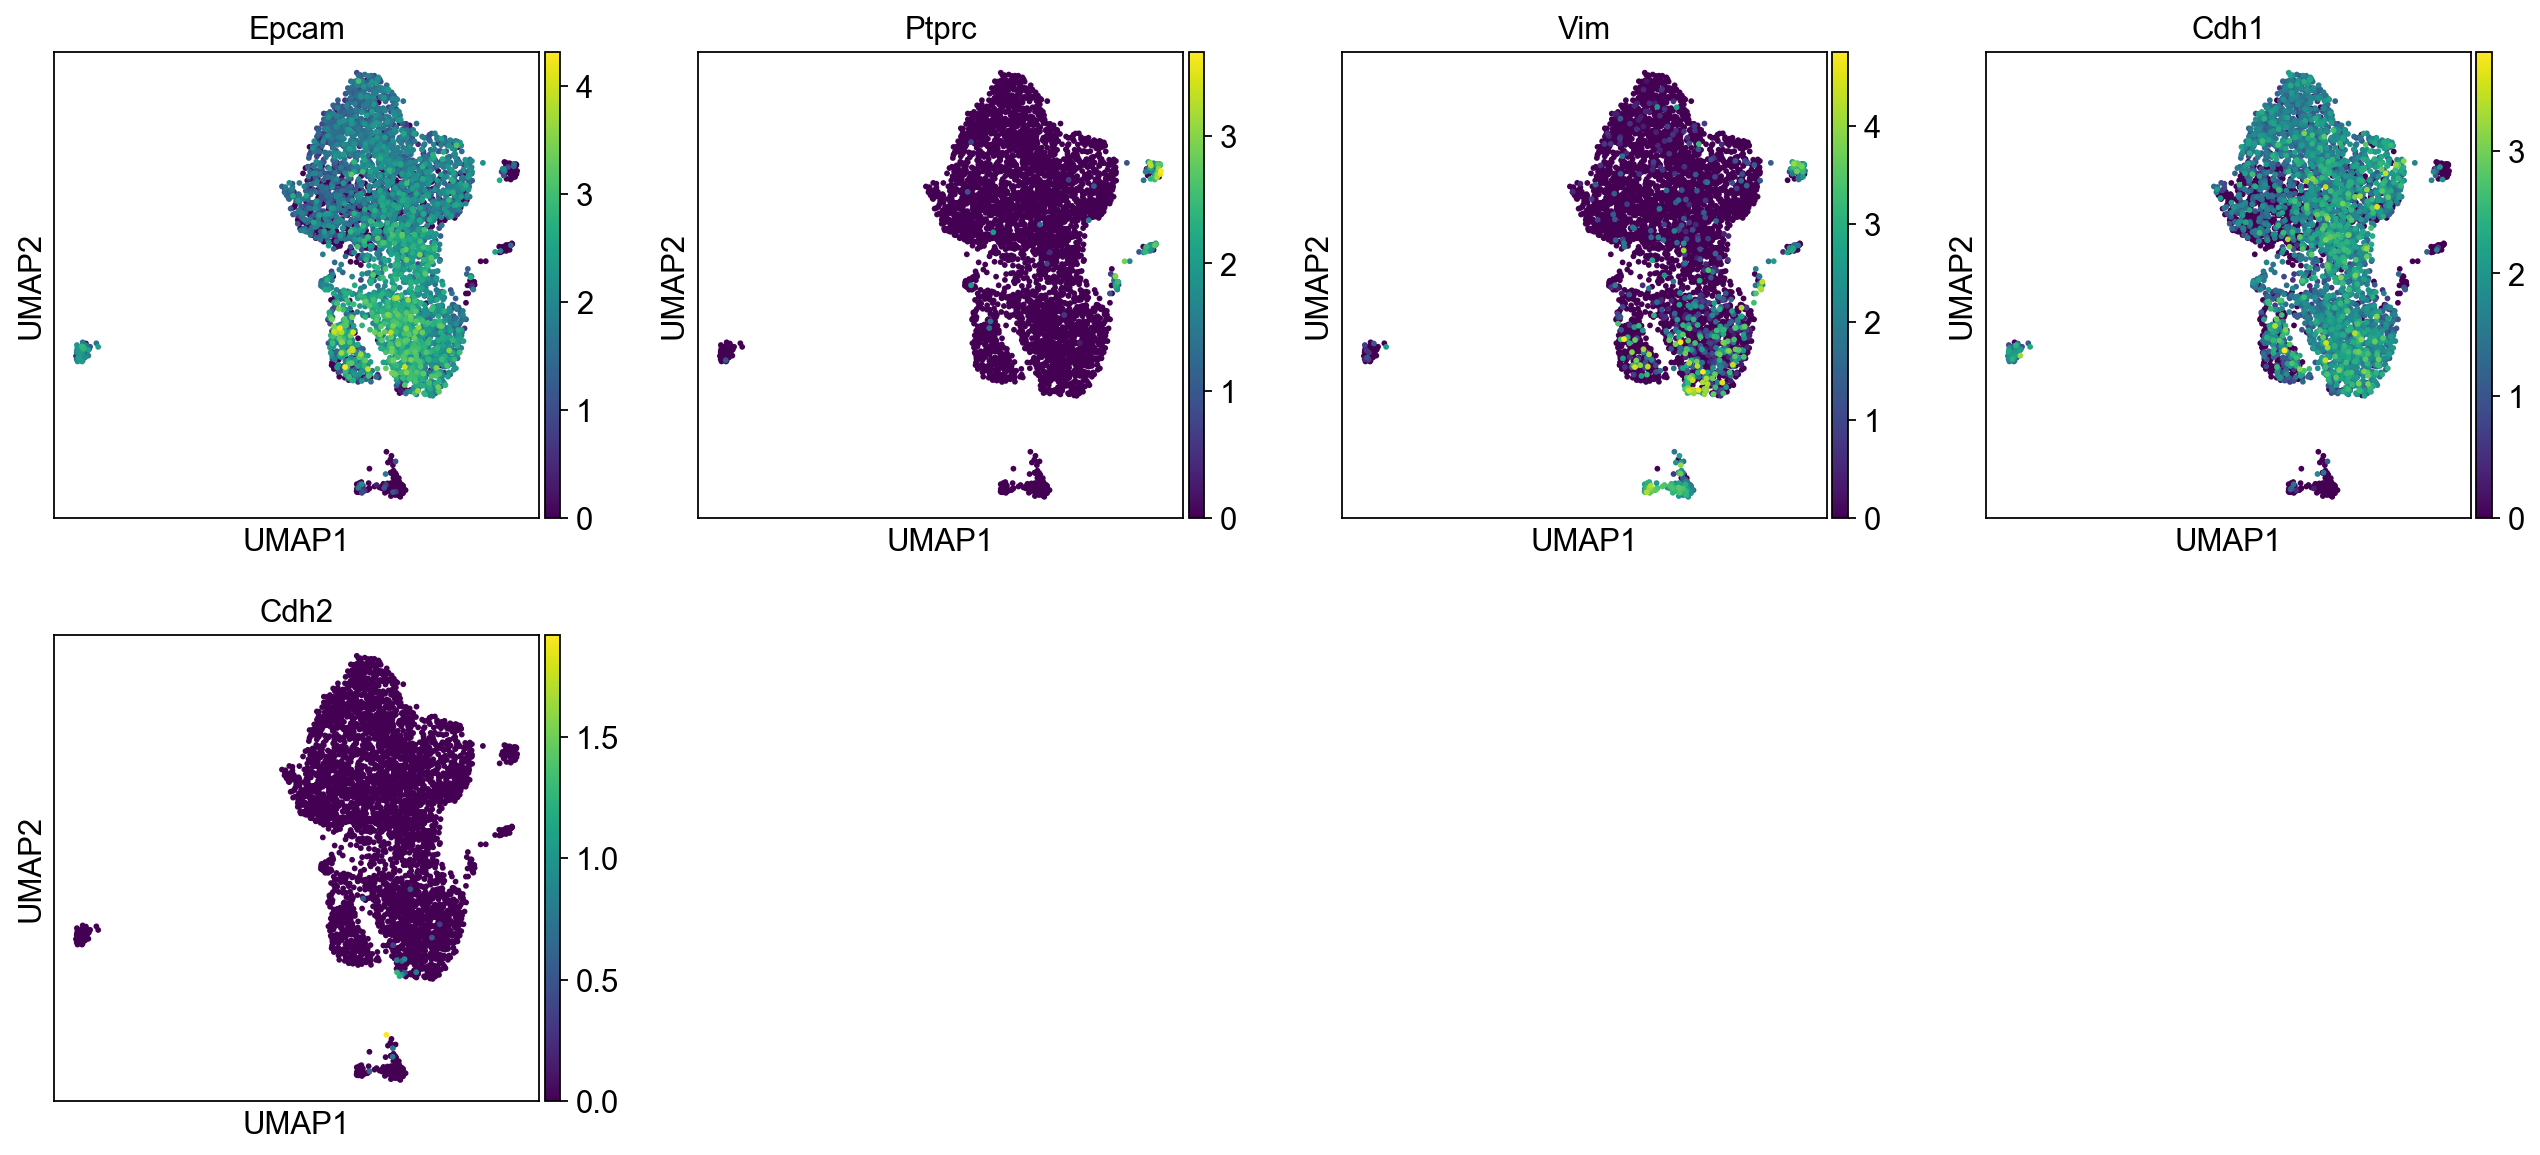

In [75]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1','Cdh2'])

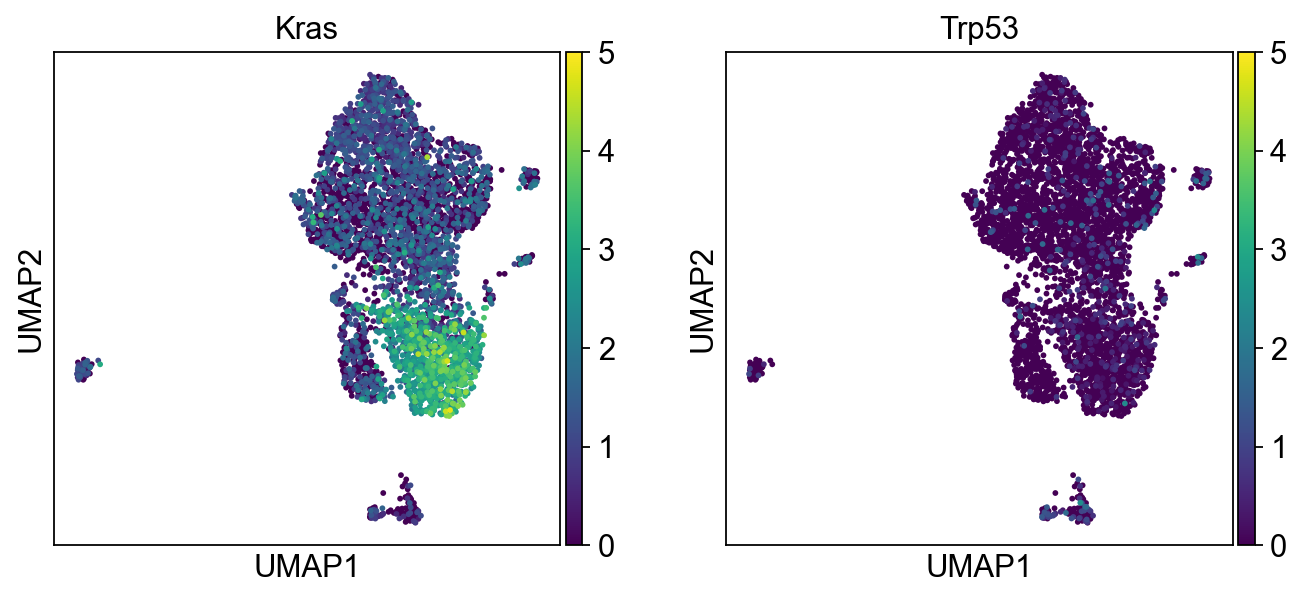

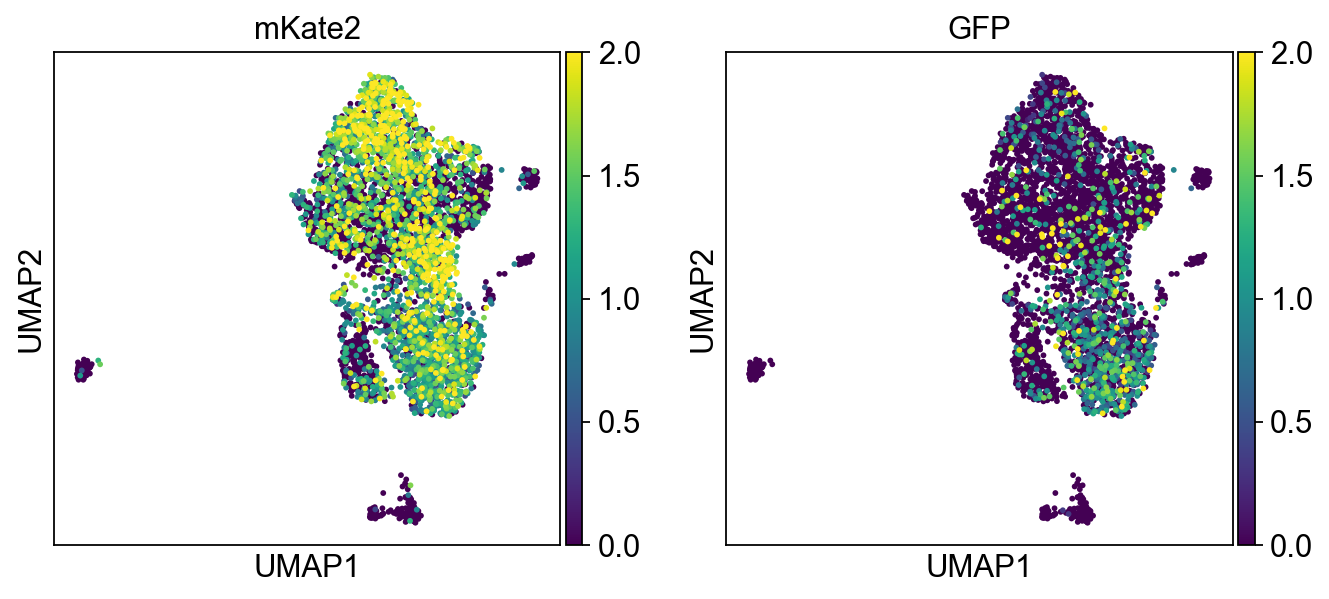

In [76]:
sc.pl.umap(adata, color=['Kras','Trp53'], vmax=5)
sc.pl.umap(adata, color=['mKate2','GFP'], vmax=2)

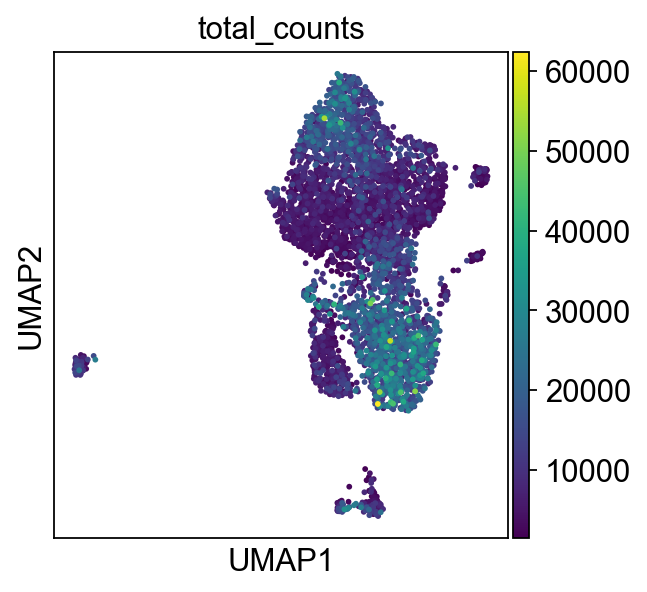

In [77]:
sc.pl.umap(adata, color=['total_counts'])

In [78]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [79]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [80]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1587 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1491 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1491 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1591 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1692 total control genes are used. (0:00:00)
computing score 'Cluster 6'
       'Gm6139'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2193 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.

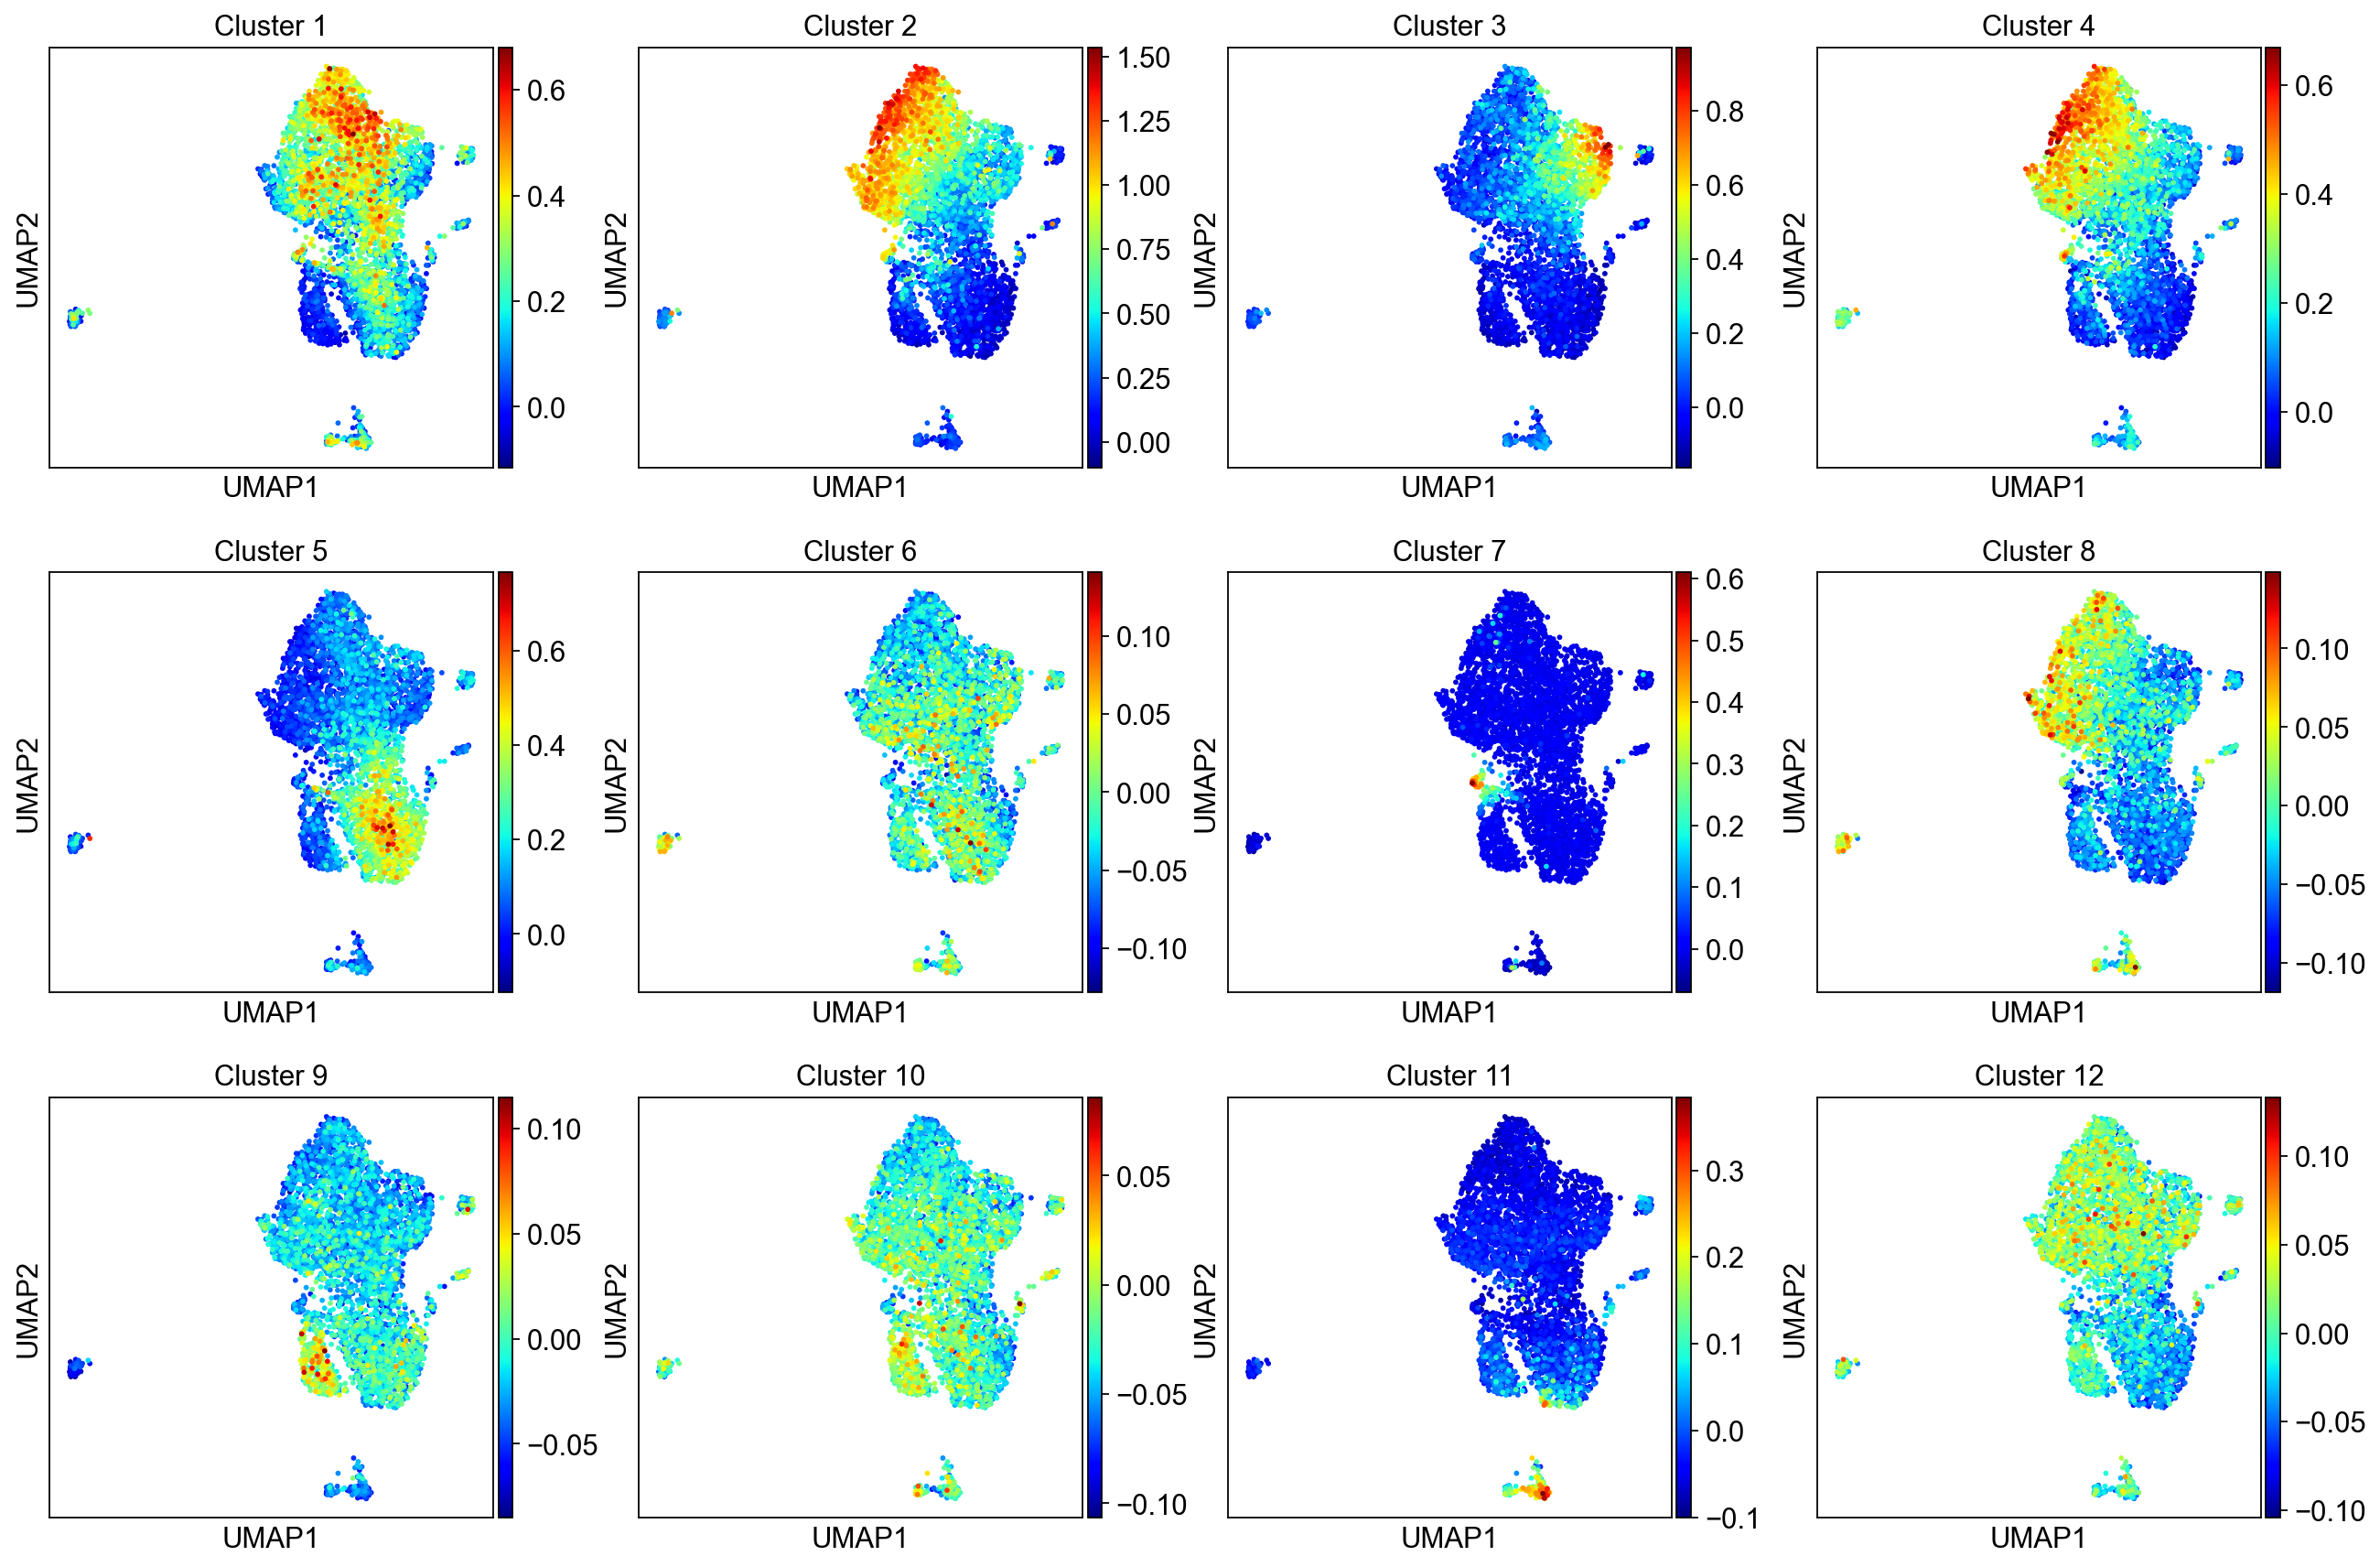

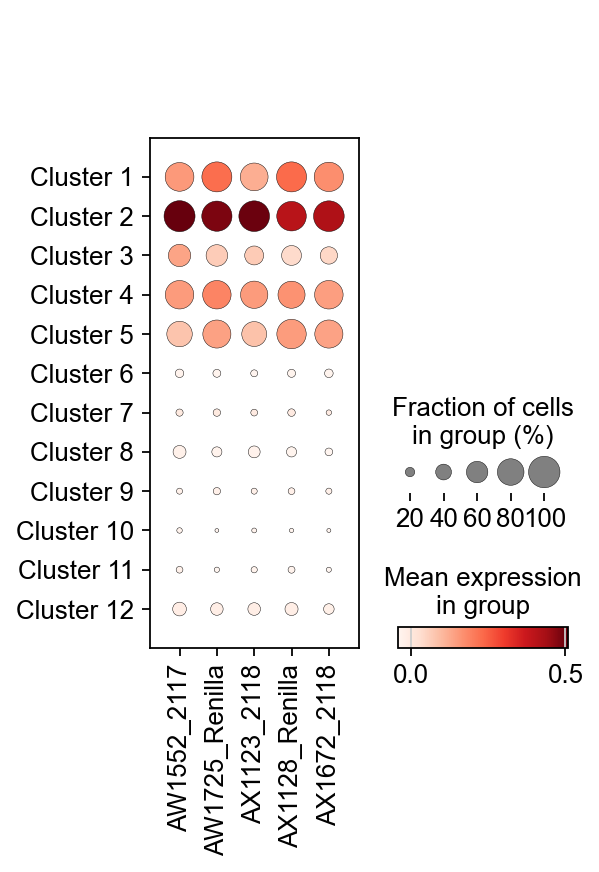

In [81]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [82]:
sc.tl.leiden(adata, resolution=0.3)
#sc.tl.leiden(adata, resolution=0.25)

running Leiden clustering


/tmp/ipykernel_1960023/3206119172.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


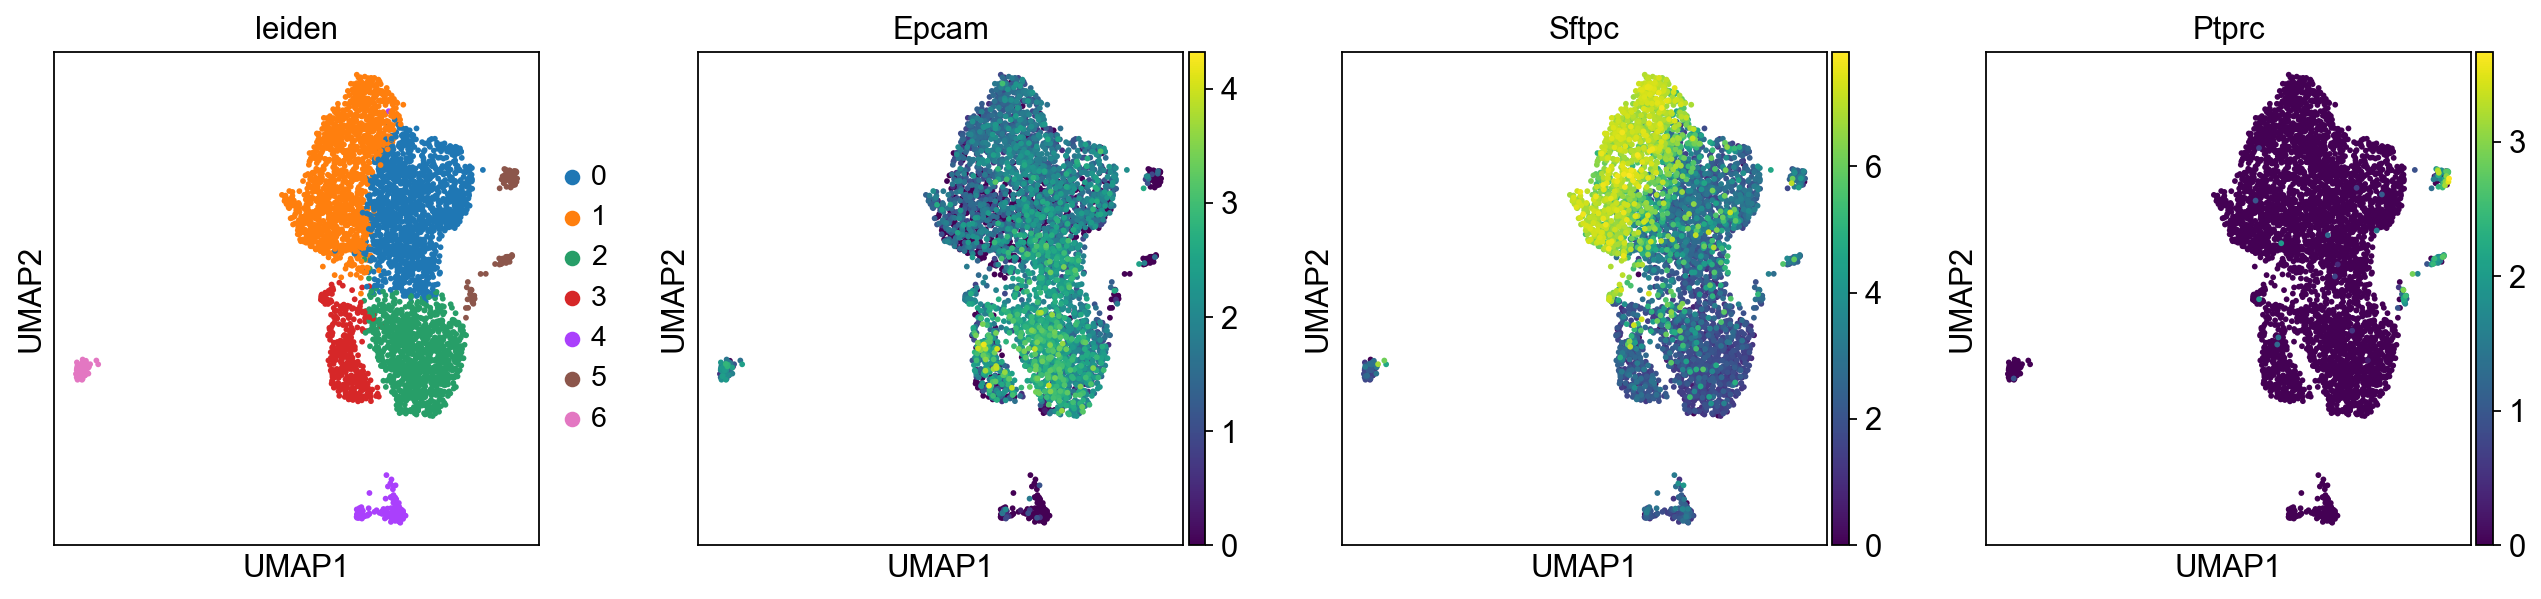

(None,)

In [83]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

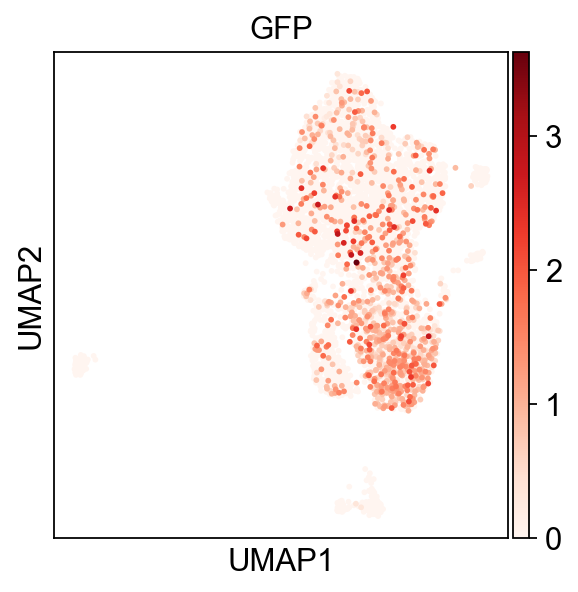

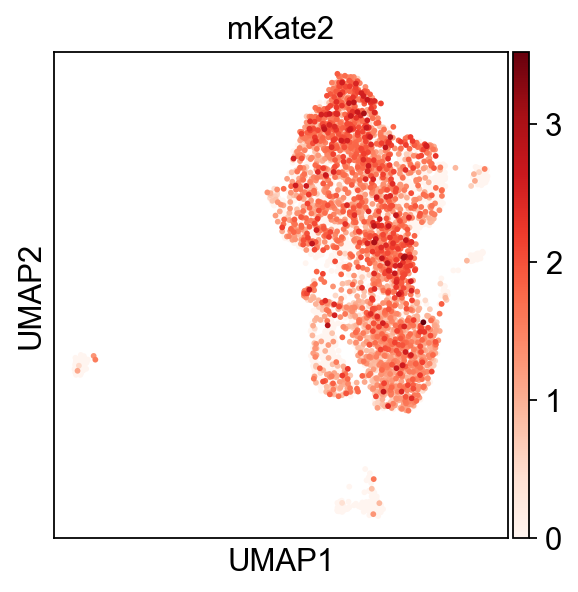

In [84]:
sc.pl.umap(adata, color=['GFP'], cmap='Reds')
sc.pl.umap(adata, color=['mKate2'], cmap='Reds')

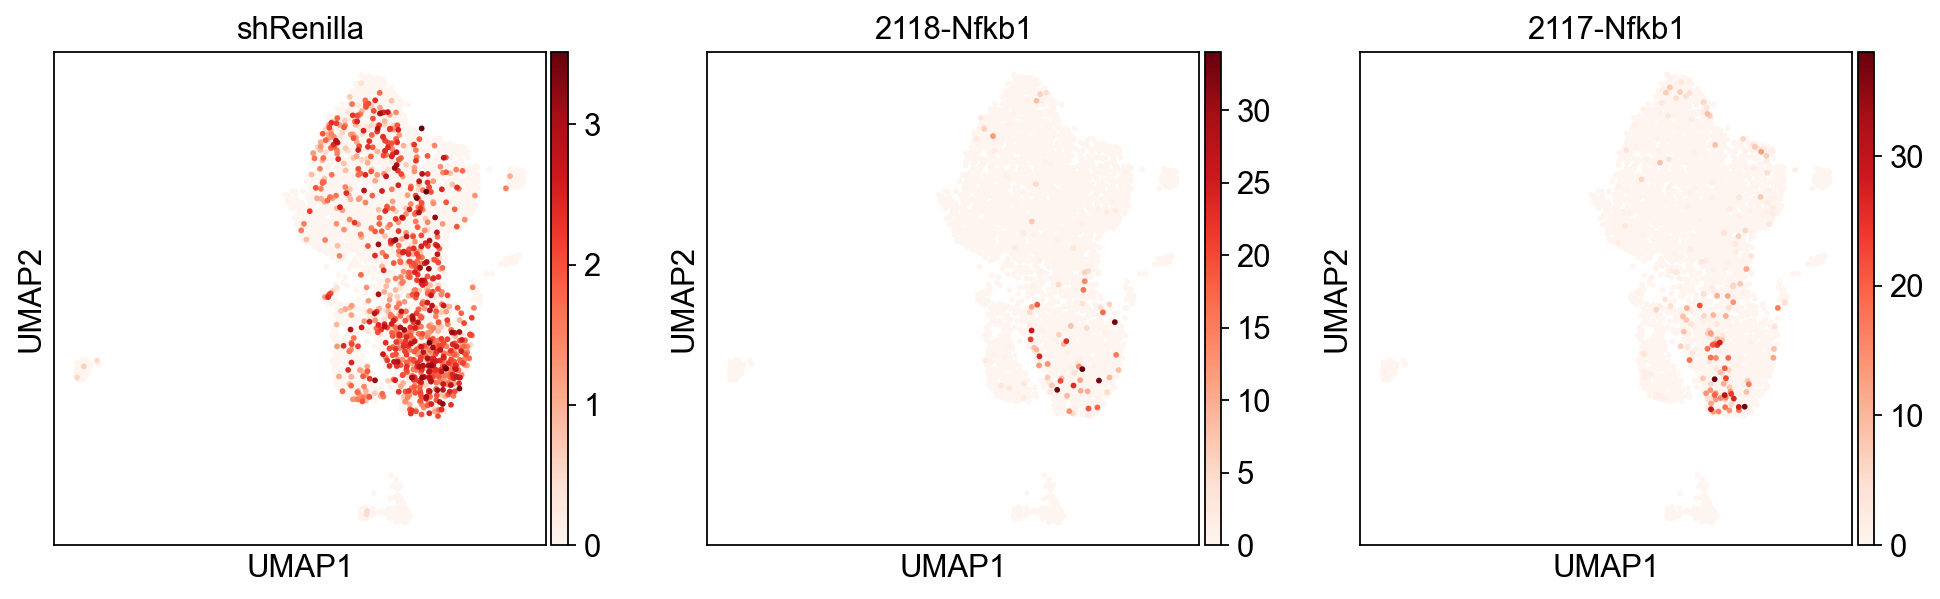

In [85]:
sc.pl.umap(adata, color=["shRenilla", "2118-Nfkb1", "2117-Nfkb1"], cmap='Reds')

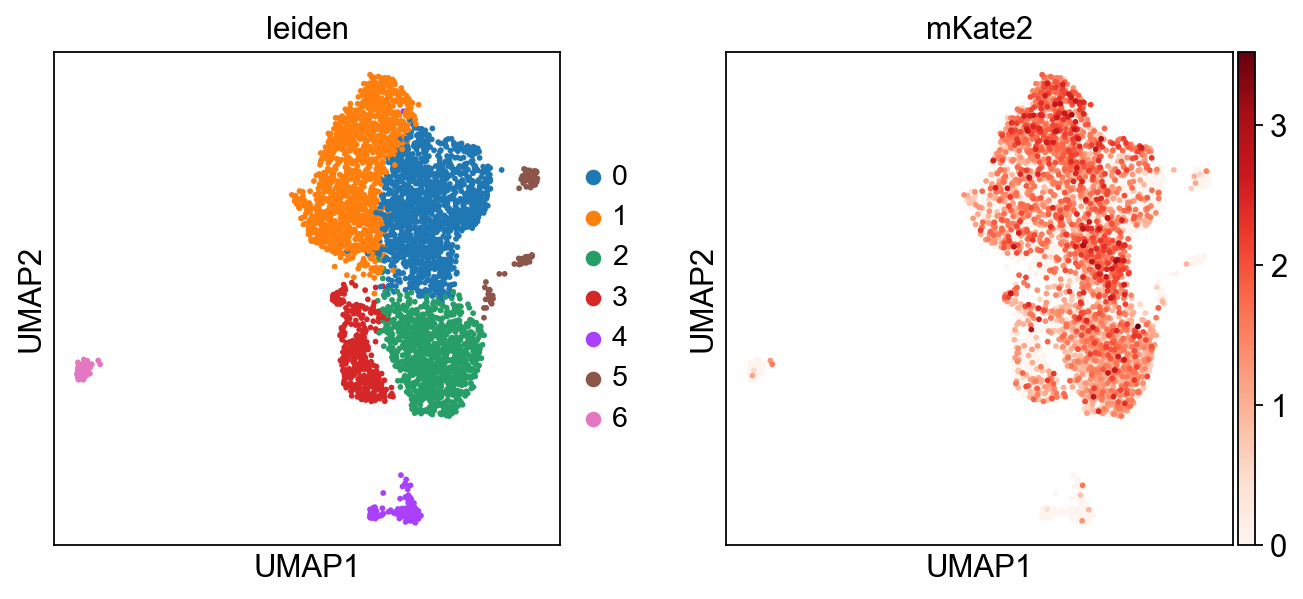

In [86]:
sc.pl.umap(adata, color=['leiden','mKate2'],cmap="Reds")

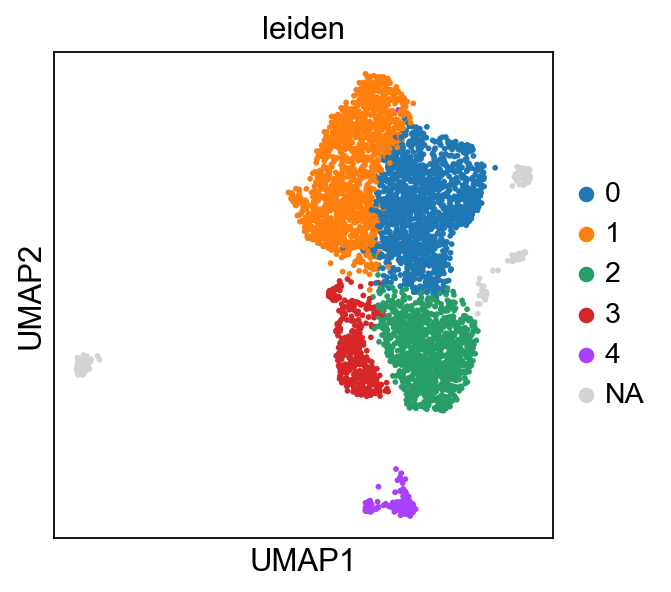

In [87]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','3','4'])

## Select Tumor Cells

In [88]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/JC2438-allmice.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','3','4']),:] # keep tumor cells
del adata2

In [89]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/tmp/ipykernel_1960023/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [90]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [91]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['GFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Cre'] = False
for x in library:
    adata.var.highly_variable[x] = False

/tmp/ipykernel_1960023/2494002207.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['GFP'] = False
/tmp/ipykernel_1960023/2494002207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

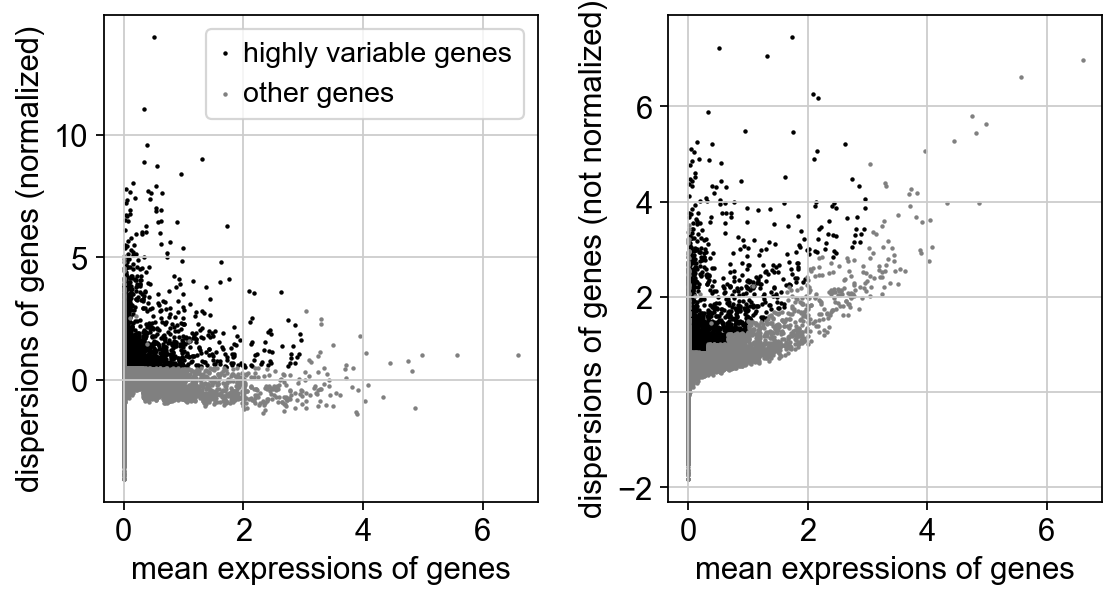

In [92]:
sc.pl.highly_variable_genes(adata)

In [93]:
adata.raw = adata

In [94]:
adata.write('write/JC2438-allmice-tumor.h5ad', compression='gzip')
#adata = sc.read('write/JC2438-allmice-tumor.h5ad')